# Sriram et al. (2012) Model Code

# Table of Contents
1. [Instructions](#instructions)
    1. [Parameter Optimization Against TSST Data Sets](#TSSTInstructions)
    2. [Parameter Optimization Against Basal Data Sets](#basalInstructions)
    3. [Running Without Parameter Optimization](#noOptInstructions)
2. [Imports](#imports)
3. [Parameters and Initial Conditions](#params)
4. [Put Raw Data into Arrays](#rawdata)
    1. [Plot Basal Data Sets](#plotBasalData)
    2. [Plot Nelson Data Sets](#plotNelsonData)
5. [Model Function--Includes ODE Solver](#modelfunction)
6. [Functions to Determine Delayed ACTH and Cortisol Values](#delays)
7. [Cost Function Definition](#cost)
8. [Run the Optimization](#run)
9. [Save Output to File](#saveoutput)
10. [Compute Means and Std Devations of Parameters and Output as Table](#paramtable)
11. [Plots](#plots)
12. [Figure 3 Reproduction](#fig3)
13. [Figure 4 Reproduction](#fig4)
14. [Load Parameter Sets, Run Model and Save Hormone Concentration Data](#loadparams)
15. [Checking Parameter Sets Generated Externally](#checkexternal)
16. [Load Simulated Concentration Data from Files and Plot](#load-and-plot)
17. [Testing Monte Carlo Optimization](#monte)
18. [Dependencies](#dependencies)

## Instructions <a name="instructions"></a>

### Parameter Optimization Against TSST Data Sets <a name="TSSTInstructions" />

**Note:** To quickly run a cell (or a selection of cells), use the shortcut Shift+Enter (or you can also use the button labeled "Run" in the toolbar at the top).

To run simulations with parameter optimization against TSST data, there is no need to change any cells until the cost function cell. Simply run all cells up to the cell below the heading **Cost Function Definition**.

In order to set which data set to optimize parameters against, look for the following line of code in the cost function definition:
    
    return costFun.cost(...)

**Note:** You also have the option of using a cost function based on the maximum distance between simulation and real-world data. Simply change SSE_cost to MAX_cost, the instructions for function arguments remain the same.

In order to run against a patient from the TSST data sets, simply change the second and fourth arguments to reflect the patient number and subject group. The subject groups are:

- nelsonMelancholicACTH & nelsonMelancholicCortisol (15 patients)
- nelsonAtypicalACTH & nelsonAtypicalCortisol (14 patients)
- nelsonNeitherACTH & nelsonNeitherCortisol (14 patients)
- nelsonHealthyACTH & nelsonHealthyCortisol (15 patients)

You could also run against the mean of all patients cortisol and ACTH concentration values by using `nelsonACTH[:,1]` and `nelsonCortisol[:,1]`. Or you can run against the mean of any subgroup using `nelson<subgroup name>Cortisol_mean` and `nelson<subgroup name>ACTH_mean` without any indices (for instance `nelsonMelancholicCortisol_mean` & `nelsonMelancholicACTH_mean`).

The following are several examples of arguments you could pass the cost function with explanations:

- `nelsonACTH[:,0], nelsonMelancholicACTH[:,0], nelsonCortisol[:,0], nelsonMelancholicCortisol[:,0], simData`
    - The 1st patient in the Melancholic subgroup (Python array indexing starts at 0!)
- `nelsonACTH[:,0], nelsonAtypicalACTH[:,13], nelsonCortisol[:,0], nelsonAtypicalCortisol[:,13], simData`
    - The 14th patient in the Atypical subgroup
- `nelsonACTH[:,0], nelsonHealthyACTH[:,3], nelsonCortisol[:,0], nelsonHealthyCortisol[:,3], simData`
    - The 2nd patient in the Control group
- `nelsonACTH[:,0], nelsonACTH[:,1], nelsonCortisol[:,0], nelsonCortisol[:,1], simData`
    - The mean data set for all patients (depressed and control)
- `nelsonACTH[:,0], nelsonHealthyACTH_mean, nelsonCortisol[:,0], nelsonHealthyCortisol_mean, simData`
    - The mean of all control patients
    
In order to find out the actual Patient ID of the patient you are matching, try creating a new cell and entering the following command (using the group name and index number you used in the cost function arguments):

    print(melancholic_ids[0])
    
Next, you need to set the initial conditions for each ODE. In the cell directly below the heading **Run the Optimization**, you'll need to change the following line:

    y0 = [1, nelsonMelancholicACTH[0,0], nelsonMelancholicCortisol[0,0], 2]
    
Depending on which data set you used, change `nelsonMelancholicACTH` and `nelsonMelancholicCortisol` to match. Then, depending on which patient you used, change `[0,0]` in both places to `[0,#]` where # is replaced with the number from above. 

Alternatively, if you used the mean of all patients, you'd use:

    y0 = [1, nelsonACTH[0,1], nelsonCortisol[0,1], 2]
    
And for each of the subgroup means, you'd use (or simply replace Healthy with whichever other subgroup you used):

    y0 = [1, nelsonHealthyACTH_mean[0], nelsonHealthyCortisol_mean[0], 2]
    
When optimizing the initial conditions that you don't have data for (so CRH and GR when matching Nelson data), you'll need to change the definition of `y0` in the definition of `cost_fun` to the same thing as you used above, except with the values for CRH and GR changed to `params[0]` and `params[1]`, respectively. For the mean of all patients in the Nelson data, it should look like:
    
    y0 = [params[0], nelsonACTH[0,1], nelsonCortisol[0,1], params[1]]
    
You'll also need to only pass the array params from the 3rd index on as parameters for the ODE solver (since the first two arrays are ICs, instead):

    simData = model(params[2:], y0)

At this point, you are ready to run the optimization, so simply run the cells up to the heading **Save Output to File**. This may take some time, so while it is running you can move on to the next steps (if you run a cell while another is processing, it will add it to a queue).

The next few cells under the heading **Save Output to File** can be changed so that the filenames match the subgroup and patient you are running. For instance, the filename below is for the Melancholic subgroup patient with ID 3:

    df_t.to_excel(excel_writer = 'sriramModel_output/sriramModel-nelson-melancholic-patientID_3-timeSteps-5-
        iterations.xlsx')
    
The final step after saving the outputs is to plot the simulations against the real-world data. The cell under the heading **Plots** contains the code for this purpose. The lines of concern to ensure that you're showing the data set that you matched are (marked with comments in the actual code cell):
```
ax2.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,0], label = "Nelson Melancholic MDD ACTH Data - 
    Patient ID 3", color = "orange")
ax3.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,0], label = "Nelson Melancholic MDD Cortisol Data - 
    Patient ID 3", color = "orange")
```
Here, change the first two arguments of each line to match exactly the arguments you used for the cost function. The labels can be changed to the patient subgroup and Patient ID you matched, also. And the filename for the figure can be changed in the last line of the cell:

    plt.savefig("sriramModel_output/sriramModel-nelson-melancholic-patientID_3-5-iterations-all-params-
        normalizedCost.png", dpi = 300)
    
### Parameter Optimization Against Basal Data Sets <a name="basalInstructions" />

Since these data sets have data points over a 24-hour period, rather than 2.35 hours, you will need to change the time interval over which the ODE solver integrates. To do this, go to the cell directly above the heading **Put Raw Data Into Arrays** and change the value of t_end to the following:

    t_end = 24.26

The reason you add the extra 0.26 hours is that you need to make sure that when you interpolate between your simulated data points the line covers every real-world data point so that you don't cause issues when computing the cost function (and the last data point for the Golier cortisol concentration data sets is at 24.25 hours).

After making this change, you need to again change the cost function arguments so that you are matching the basal data set in which you are interested. This time, however, you will also need to change the first and third arguments, because we need to tell the function the correct time steps for the data set.

First, choose which data set you wish to match. Here are the options:

- yehudaControlCortisol
- yehudaPTSDCortisol
- yehudaDepressedCortisol
- carrollControlCortisol & carrollControlACTH
- carrollLCDepressedCortisol & carrollLCDepressedACTH (LC = Low Cortisol)
- carrollHCDepressedCortisol & carrollHCDepressedACTH (HC = High Cortisol)
- golierPTSDCortisol & golierPTSDACTH
- golierNonPTSDTraumaExposedCortisol & golierNonPTSDTraumaExposedACTH
- golierNonPTSDNonExposedCortisol & golierNonPTSDNonExposedACTH
- bremnerAbusedPTSDCortisol
- bremnerNonAbusedPTSDCortisol
- bremnerNonAbusedNonPTSDCortisol

**Note:** To see what any of these data sets looks like, click on the **Plot Basal Data Sets** heading in the Table of Contents.

**Note Also:** These data sets all come in smoothed versions (each data point is set to the average of the nearest 5 points of the unsmoothed data). Also, the data sets by Carroll, Golier and Bremner also come in rearranged (or smoothed & rearranged) versions to match the starting time of the Yehuda data (10AM). To use any of these versions, simply append one of the following tags to the end of the data set name (before the indices): `_smooth`, `_rearr`, or `_rearr_smooth`.

First, I will cover what to do with data sets that contain both ACTH and cortisol values, and then afterwards I will cover using the Yehuda and Bremner data sets (which have only cortisol concentration data). For all of these data sets, the first column is the time step values. This means that if you take any of these arrays and index it with `[:,0]`, you are referring to the time steps. These are the values we need to pass as the first (ACTH time steps) and third (cortisol time steps) arguments to the cost function.

Then for the second and fourth arguments, you index the same data sets with `[:,1]` to mean the second column (which contains the mean concentration values for each patient group).

Here are a couple of examples showing arguments you can pass to the cost function:

- `carrollControlACTH_smooth[:,0], carrollControlACTH_smooth[:,1], carrollControlCortisol_smooth[:,0], carrollControlCortisol_smooth[:,1], simData`
    - The smoothed Control group mean for the Carroll data set
- `golierNonPTSDTraumaExposedACTH[:,0], golierNonPTSDTraumaExposedACTH[:,1], golierNonPTSDTraumaExposedCortisol[:,0], golierNonPTSDTraumaExposedCortisol[:,1], simData`
    - The Trauma-Exposed Control group mean for the Golier data set
    
In order to run simulations against data sets that do not include ACTH concentration data, you will need to change the name of the function to `costFun.cost_noACTH` and then simply do not include the two arguments for ACTH data. To use the Yehuda Control group data, this would look like:

    return costFun.cost_noACTH(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], simData)

You'll also need to change the initial conditions in the cell below the heading **Run the Optimization**, again. Use the name of the data set you used for the cost function, and change the indices to `[0,1]` for both. Here's an example (using the smoothed Carroll Control group data set):

    y0 = [1, carrollControlACTH_smooth[0,1], carrollControlCortisol_smooth[0,1], 2]
    
Next, because you changed the length of the interval over which the ODE solver integrates, you'll need to change the arrays initialized in the next cell to be longer. For each of the last 4 lines in the cell, you'll need to replace the number 237 with 2427 (since we start at -0.01 and go until 24.26 with a step size of 0.01, that's 2427 steps total).

At this point, you're ready to run the parameter optimization, so run the next cell. Again, it may take a while, so you can start editing the remaining cells while you wait.

The cells under the heading **Save Output to File** should each have the filename changed to something that reflects the data set you're matching now. For instance, the Excel filename for sims_acth when matching the smoothed Carroll Control group would become:

    df_crh.to_excel(excel_writer = 'sriramModel_output/sriramModel-carroll-control-smooth-sims-crh-5-
        iterations.xlsx')
            
Finally, the cell under the heading **Plots** needs to have the same lines changed as described above. For instance, when matching the smoothed Carroll Control group, they would become:
```
ax2.plot(carrollControlACTH_smooth[:,0], carrollControlACTH_smooth[:,1], label = "Carroll Control ACTH Data", 
    color = "orange")
ax3.plot(carrollControlCortisol_smooth[:,0], carrollControlCortisol_smooth[:,1], label = "Carroll Control 
    Cortisol Data", color = "orange")
```
The data set names and indices here should match exactly the names and indices used as arguments to the cost function. Also, the last line of the cell can have the filename changed as described above to reflect which data set you are plotting.

### Running Without Parameter Optimization <a name="noOptInstructions" />

To reproduce Figures 3 & 4 from the Sriram et al. (2012) paper, you do not need to modify any code. Simply run all cells in the sections labeled **Figure 3 Reproduction** and **Figure 4 Reproduction**.

To run the model with any set of paramaters you desire, without optimization, you can use the cells under the heading **Load Parameter Sets, Run Model and Save Hormone Concentration Data**.

Either set the filename with the parameter set you wish to load, or uncomment the cell below that with the line:

    #loaded_params = authors_params
    
Uncommenting (delete the #) this will simply set the parameters you are using to the parameters defined in the section **Parameters and Initial Conditions**. After setting the parameters in either fashion, you can then run the remaining cell under the heading **Load Parameter Sets, Run Model and Save Hormone Concentration Data** and then run the cell under **Plots** to create plots of the result. You can simply comment out (add # at the start of the line) the lines you edited above to change which real-world data was displayed along with the simulations.

## Imports <a name="imports"></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate
import matplotlib
import pandas as pd
from HPAmodeling import ODEsolver, costFun, dataImport
import paramonte as pm
import seaborn as sns

print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
sns.set()

numpy 1.21.5
mpld3 0.3.1.dev1
matplotlib 3.0.1
pandas 0.23.4
paramonte 2.5.2
seaborn 0.10.1


## Parameters and Initial Conditions <a name="params"/>

In [3]:
# it looks, based on the XPP file from the authors, like they start CRH, ACTH, CORT and GR at 0 each and just run
# the solver until they reach some steady state

y0 = [1,28.7,8.6123,2]

In [4]:
# initialize parameter values for use when running without parameter optimization
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 10.1 # normal: 10.1, depressed: 13.7, PTSD: 17.5
k_i = 1.51      # normal: 1.51, depressed: 1.60, PTSD: 1.17
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [5]:
# here are the bounds used for all of the parameters
bounds = [(5,20), (0.5,3), (3,4), (1,2), (7,11), (0.5,1.5), (0.08,2), (0.5,1.2), (0.001,0.008), (0.03,0.08), (0.002,0.005), (0.001,0.01), (0.1,0.5), (4,6), (4,6), (0.008,0.05), (2,5), (0.01,0.07), (0.2,0.7), (0.04,0.09)]

In [6]:
# wider bounds for fitting other data sets than original
bounds = [(1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9)]

In [7]:
# wider bounds WITH p_stress included for Nelson data
bounds = [(1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9), (1,100)]

In [8]:
# wider bounds WITHOUT p_stress included for Nelson data
bounds = [(1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9)]

In [9]:
# wider bounds WITHOUT p_stress included for Nelson data
#
# first two bounds are for CRH and GR initial conditions, respectively
bounds = [(10,70), (0,10), (1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9)]

In [10]:
# time interval and step definition, based on XPP model from authors
t_start = -0.01
t_end = 2.35
t_step = 0.01

## Put Raw Data Into Arrays <a name="rawdata"/>

In [11]:
(yehudaControlCortisol, 
 yehudaControlCortisol_smooth, 
 yehudaPTSDCortisol, 
 yehudaPTSDCortisol_smooth, 
 yehudaDepressedCortisol, 
 yehudaDepressedCortisol_smooth) = dataImport.yehuda()

In [12]:
(carrollControlCortisol, 
 carrollControlCortisol_rearr, 
 carrollControlCortisol_smooth, 
 carrollControlCortisol_rearr_smooth, 
 carrollControlACTH, 
 carrollControlACTH_rearr, 
 carrollControlACTH_smooth, 
 carrollControlACTH_rearr_smooth, 
 carrollHCDepressedCortisol, 
 carrollHCDepressedCortisol_rearr, 
 carrollHCDepressedCortisol_smooth, 
 carrollHCDepressedCortisol_rearr_smooth, 
 carrollHCDepressedACTH, 
 carrollHCDepressedACTH_rearr, 
 carrollHCDepressedACTH_smooth, 
 carrollHCDepressedACTH_rearr_smooth, 
 carrollLCDepressedCortisol, 
 carrollLCDepressedCortisol_rearr, 
 carrollLCDepressedCortisol_smooth, 
 carrollLCDepressedCortisol_rearr_smooth, 
 carrollLCDepressedACTH, 
 carrollLCDepressedACTH_rearr, 
 carrollLCDepressedACTH_smooth, 
 carrollLCDepressedACTH_rearr_smooth) = dataImport.carroll()

In [13]:
(golierPTSDCortisol, 
 golierPTSDCortisol_rearr, 
 golierPTSDCortisol_smooth, 
 golierPTSDCortisol_rearr_smooth, 
 golierPTSDACTH, 
 golierPTSDACTH_rearr, 
 golierPTSDACTH_smooth, 
 golierPTSDACTH_rearr_smooth, 
 golierNonPTSDTraumaExposedCortisol, 
 golierNonPTSDTraumaExposedCortisol_rearr, 
 golierNonPTSDTraumaExposedCortisol_smooth, 
 golierNonPTSDTraumaExposedCortisol_rearr_smooth, 
 golierNonPTSDTraumaExposedACTH, 
 golierNonPTSDTraumaExposedACTH_rearr, 
 golierNonPTSDTraumaExposedACTH_smooth, 
 golierNonPTSDTraumaExposedACTH_rearr_smooth, 
 golierNonPTSDNonExposedCortisol, 
 golierNonPTSDNonExposedCortisol_rearr, 
 golierNonPTSDNonExposedCortisol_smooth, 
 golierNonPTSDNonExposedCortisol_rearr_smooth, 
 golierNonPTSDNonExposedACTH, 
 golierNonPTSDNonExposedACTH_rearr, 
 golierNonPTSDNonExposedACTH_smooth, 
 golierNonPTSDNonExposedACTH_rearr_smooth) = dataImport.golier()

In [14]:
(bremnerAbusedPTSDCortisol, 
 bremnerAbusedPTSDCortisol_rearr, 
 bremnerAbusedPTSDCortisol_smooth, 
 bremnerAbusedPTSDCortisol_rearr_smooth, 
 bremnerNonAbusedPTSDCortisol, 
 bremnerNonAbusedPTSDCortisol_rearr, 
 bremnerNonAbusedPTSDCortisol_smooth, 
 bremnerNonAbusedPTSDCortisol_rearr_smooth, 
 bremnerNonAbusedNonPTSDCortisol, 
 bremnerNonAbusedNonPTSDCortisol_rearr, 
 bremnerNonAbusedNonPTSDCortisol_smooth, 
 bremnerNonAbusedNonPTSDCortisol_rearr_smooth) = dataImport.bremner()

In [15]:
(nelsonCortisol, 
 nelsonACTH, 
 nelsonAtypicalCortisol, 
 nelsonAtypicalACTH, 
 nelsonMelancholicCortisol, 
 nelsonMelancholicACTH, 
 nelsonNeitherCortisol, 
 nelsonNeitherACTH, 
 nelsonHealthyCortisol, 
 nelsonHealthyACTH, 
 atypical_ids, 
 melancholic_ids, 
 neither_ids, 
 healthy_ids) = dataImport.nelson()

### Plot Basal Data Sets <a name="plotBasalData"></a>

In [16]:
# convert time scales to hours for the raw data, because the model is in terms of hours
for i in range(len(yehudaControlCortisol)):
    yehudaControlCortisol[i,0] = yehudaControlCortisol[i,0]/60
    yehudaPTSDCortisol[i,0] = yehudaPTSDCortisol[i,0]/60
    yehudaDepressedCortisol[i,0] = yehudaDepressedCortisol[i,0]/60
    yehudaControlCortisol_smooth[i,0] = yehudaControlCortisol_smooth[i,0]/60
    yehudaPTSDCortisol_smooth[i,0] = yehudaPTSDCortisol_smooth[i,0]/60
    yehudaDepressedCortisol_smooth[i,0] = yehudaDepressedCortisol_smooth[i,0]/60

In [17]:
# make time scale in hours for graphing
j = 0
k = 0
l = 0

timeCarroll = np.zeros(len(carrollControlCortisol[:,0]))
for i in carrollControlCortisol[:,0]:
    timeCarroll[l] = i/60
    l += 1

In [18]:
for i in range(len(carrollControlCortisol_rearr_smooth)):
    carrollControlACTH[i,0] = timeCarroll[i]
    carrollControlACTH_rearr[i,0] = timeCarroll[i]
    carrollControlACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlACTH_smooth[i,0] = timeCarroll[i]
    
    carrollControlCortisol[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedACTH[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedACTH[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedCortisol[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedCortisol[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_smooth[i,0] = timeCarroll[i]

In [19]:
# convert the Nelson data time scale to hours, also
for i in range(len(nelsonCortisol)):
    nelsonCortisol[i,0] = nelsonCortisol[i,0]/60
    nelsonACTH[i,0] = nelsonACTH[i,0]/60

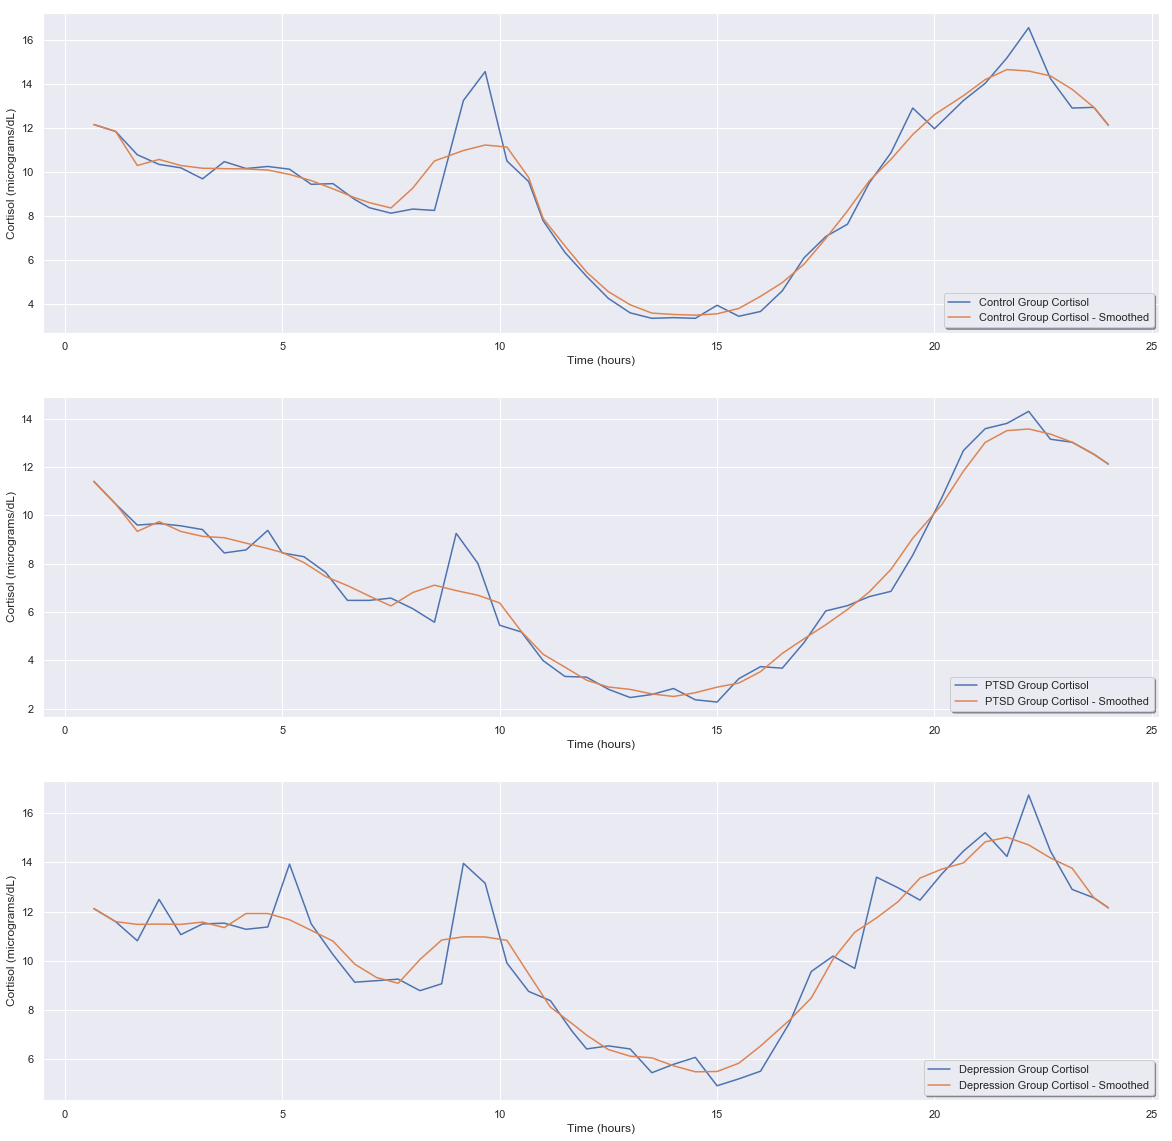

In [20]:
font = {'size'   : 18}
matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (20,20))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


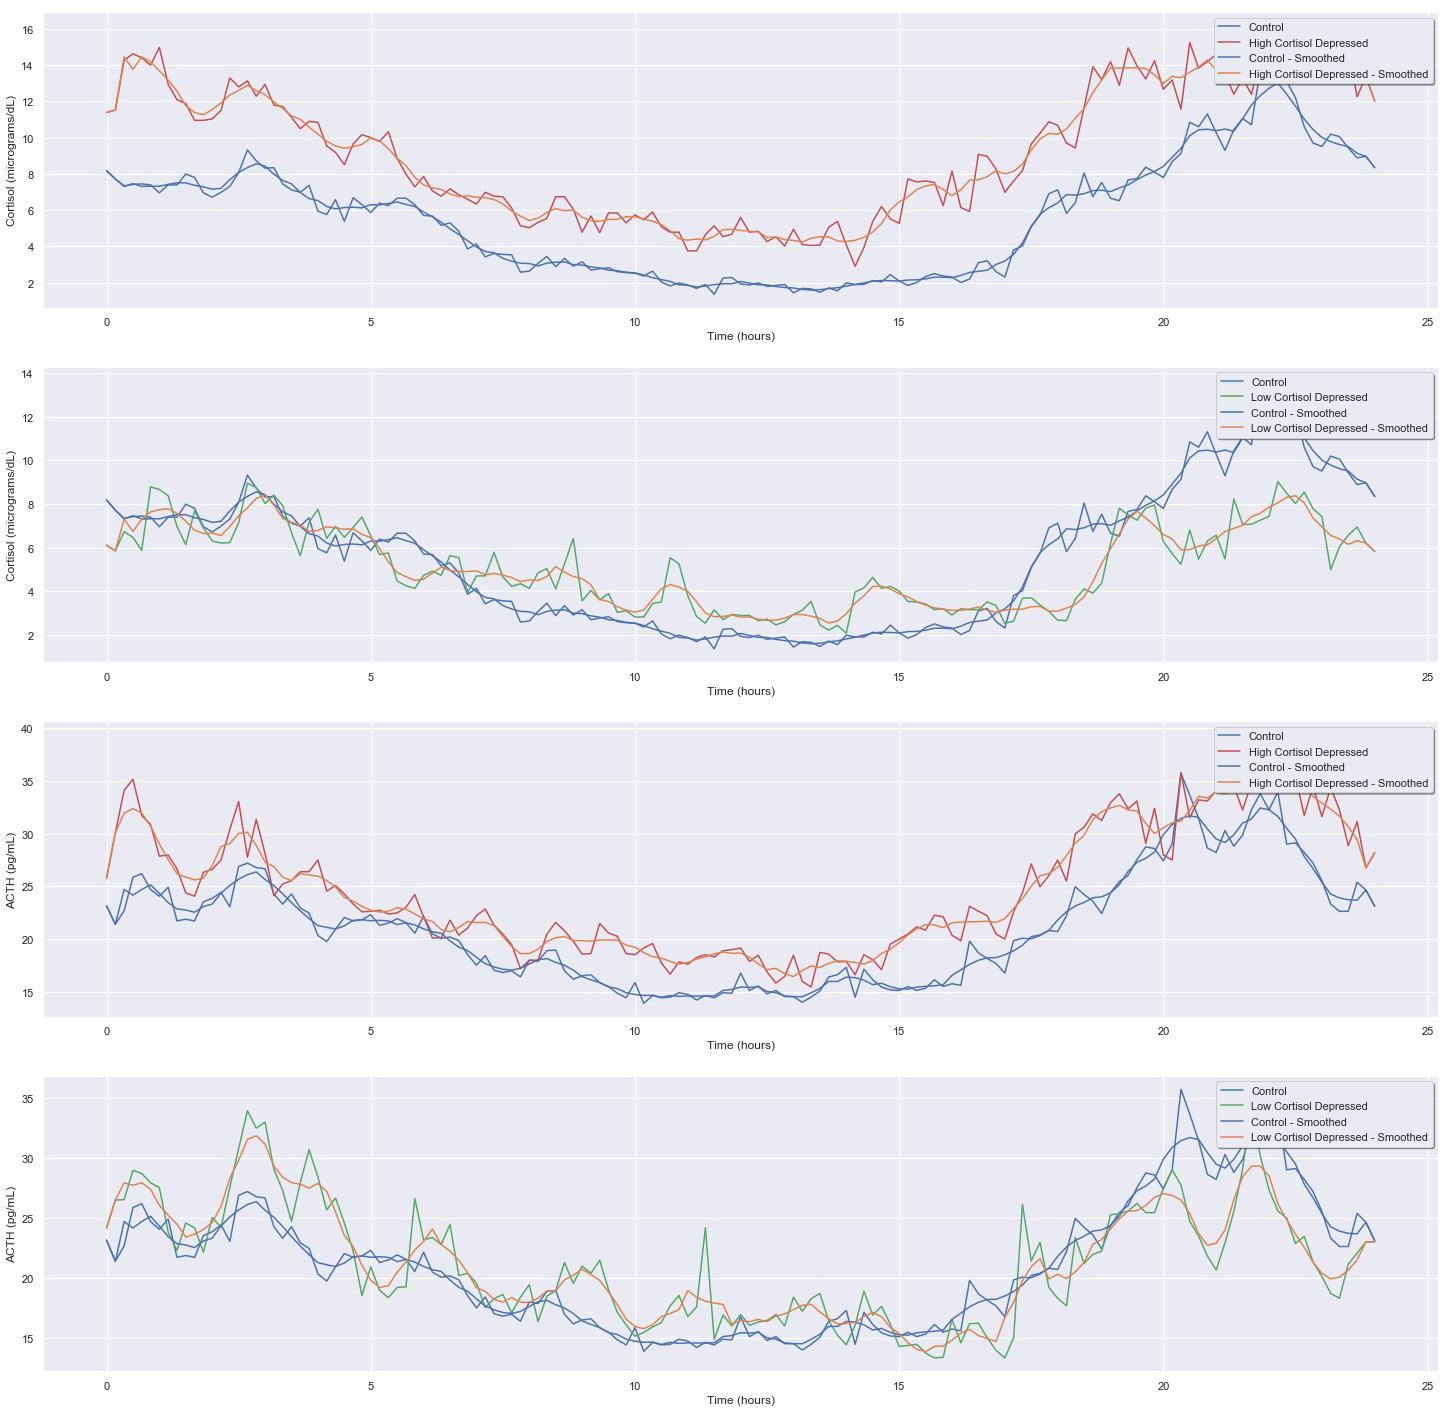

In [21]:
#mpld3.enable_notebook()
%matplotlib inline

font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (25,25))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

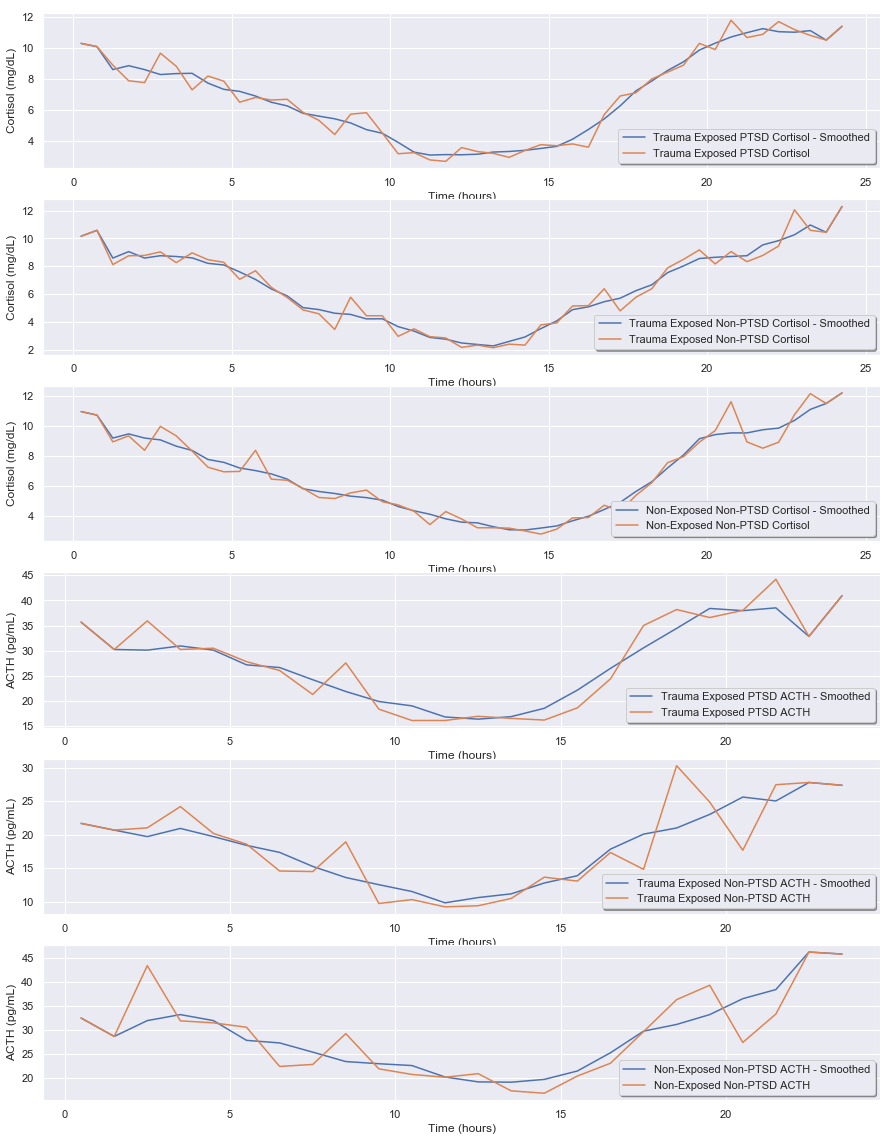

In [22]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


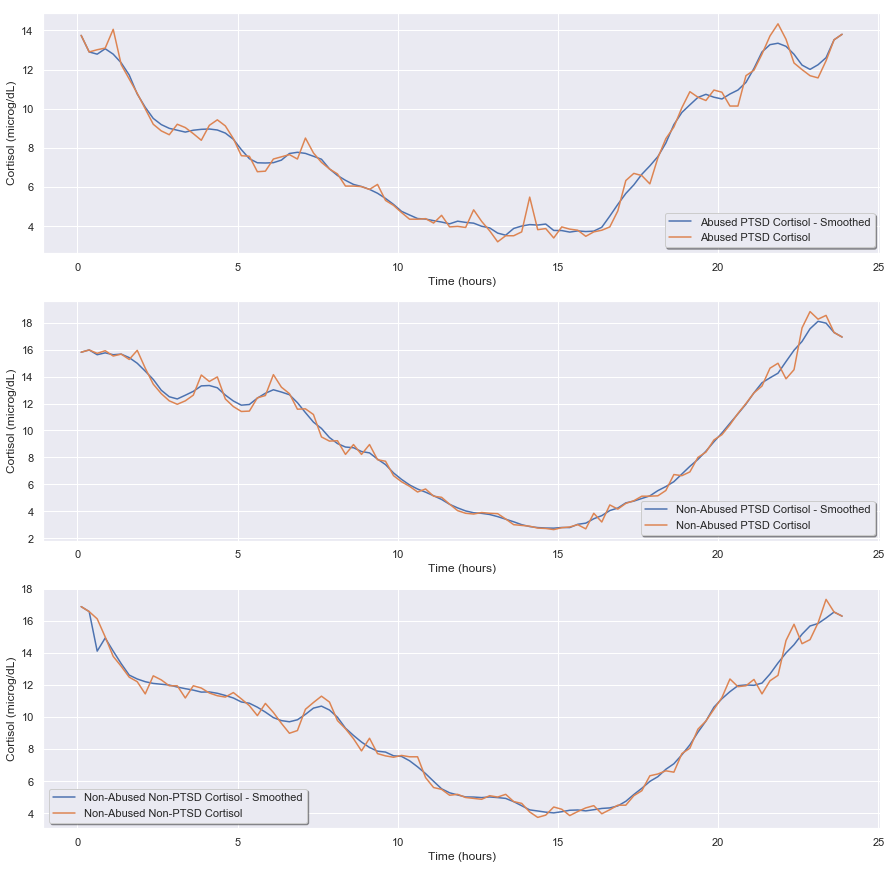

In [23]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


### Plot Nelson Data Sets <a name="plotNelsonData"></a>

[Text(0, 0.5, 'Cortisol (micrograms/dL)'),
 Text(0.5, 0, 'Time (h)'),
 Text(0.5, 1.0, 'Cortisol Concentration')]

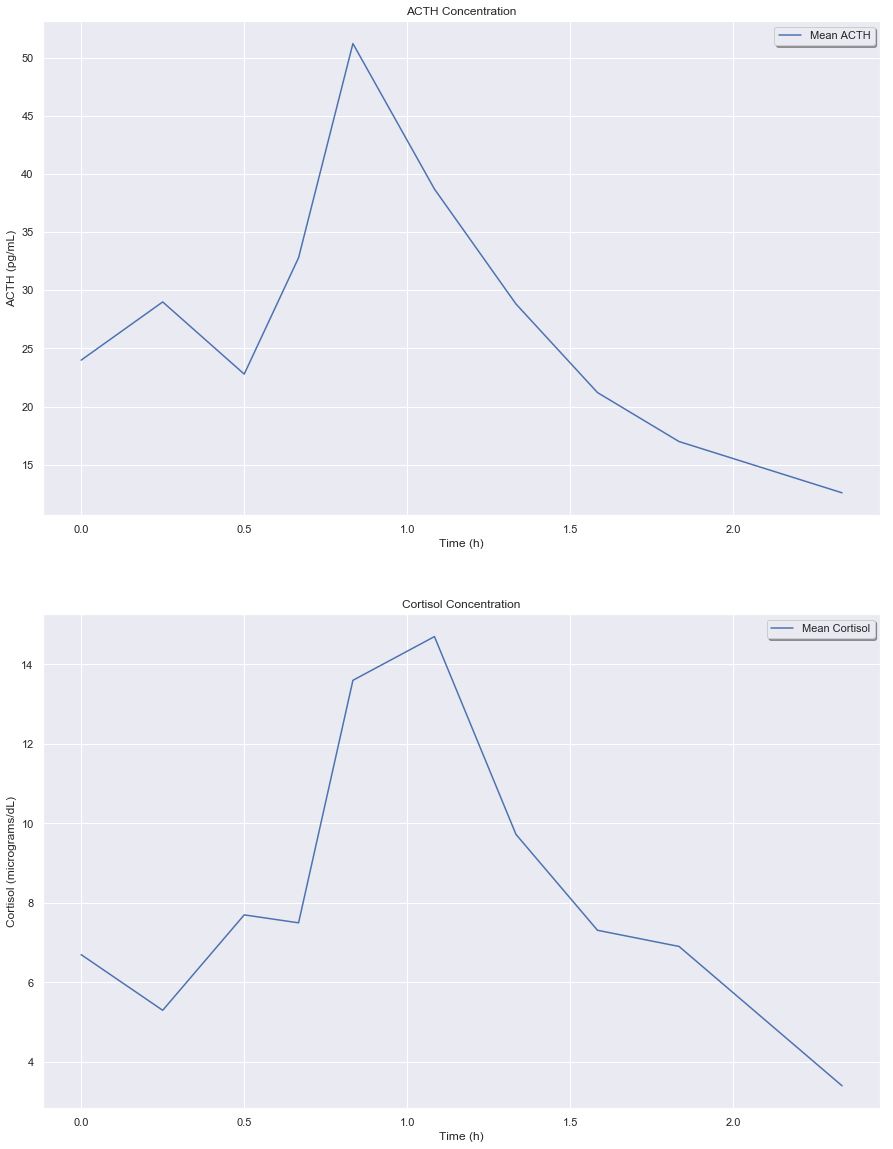

In [24]:
matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15,20))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,3], label = "Mean ACTH")
ax1.legend(loc = "upper right", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,3], label = "Mean Cortisol")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

[Text(0, 0.5, 'Cortisol (micrograms/dL)'),
 Text(0.5, 0, 'Time (h)'),
 Text(0.5, 1.0, 'Cortisol Concentration')]

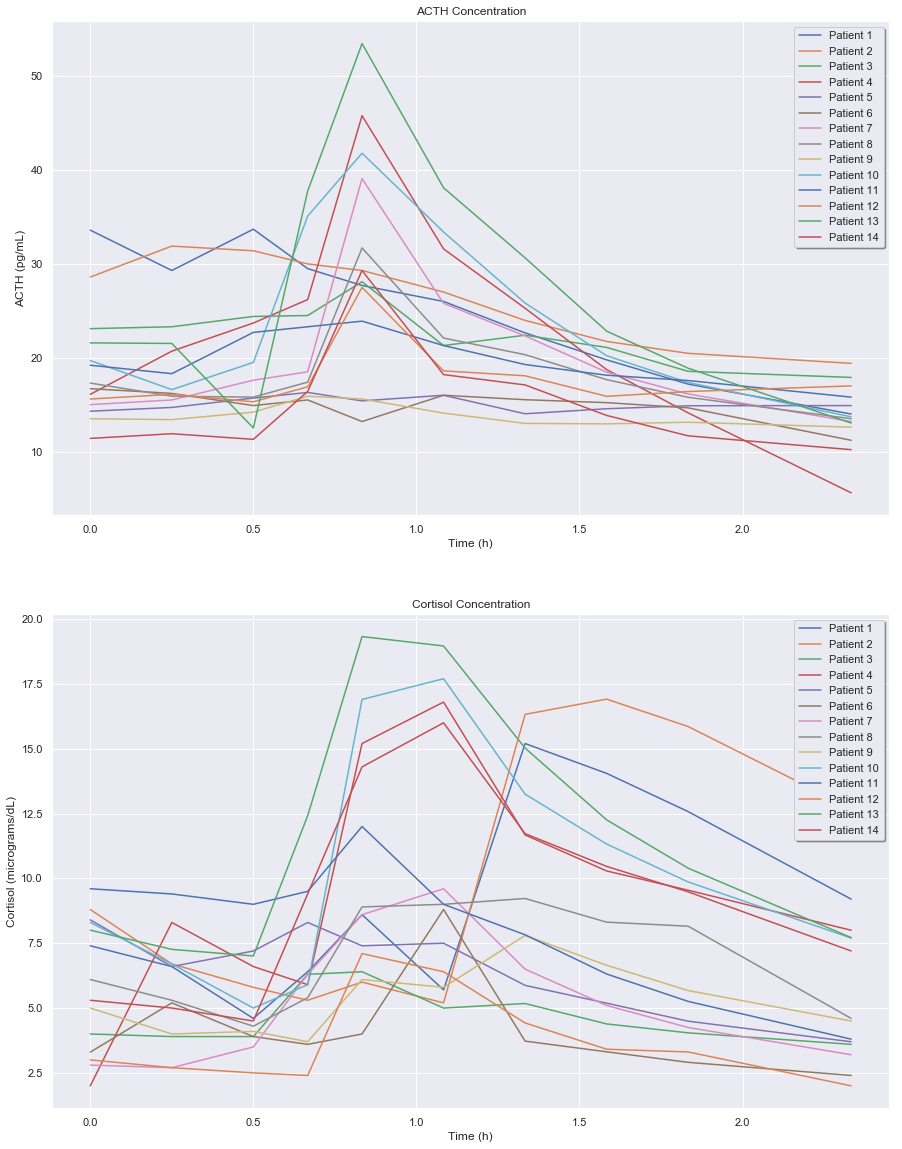

In [25]:
# graph the Nelson data (only showing one patient at a time currently)
matplotlib.rc('font', **{'size'   : 12})

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15,20))

#ax1.plot(nelsonACTH[:,0], nelsonACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,0], label = "Patient 1")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,1], label = "Patient 2")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,2], label = "Patient 3")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,3], label = "Patient 4")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,4], label = "Patient 5")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,5], label = "Patient 6")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,6], label = "Patient 7")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,7], label = "Patient 8")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,8], label = "Patient 9")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,9], label = "Patient 10")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,10], label = "Patient 11")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,11], label = "Patient 12")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,12], label = "Patient 13")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,13], label = "Patient 14")
ax1.legend(loc = "upper right", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

#ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,0], label = "Patient 1")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,1], label = "Patient 2")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,2], label = "Patient 3")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,3], label = "Patient 4")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,4], label = "Patient 5")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,5], label = "Patient 6")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,6], label = "Patient 7")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,7], label = "Patient 8")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,8], label = "Patient 9")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,9], label = "Patient 10")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,10], label = "Patient 11")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,11], label = "Patient 12")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,12], label = "Patient 13")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,13], label = "Patient 14")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

[Text(0, 0.5, 'Cortisol (micrograms/dL)'),
 Text(0.5, 0, 'Time (h)'),
 Text(0.5, 1.0, 'Cortisol Concentration')]

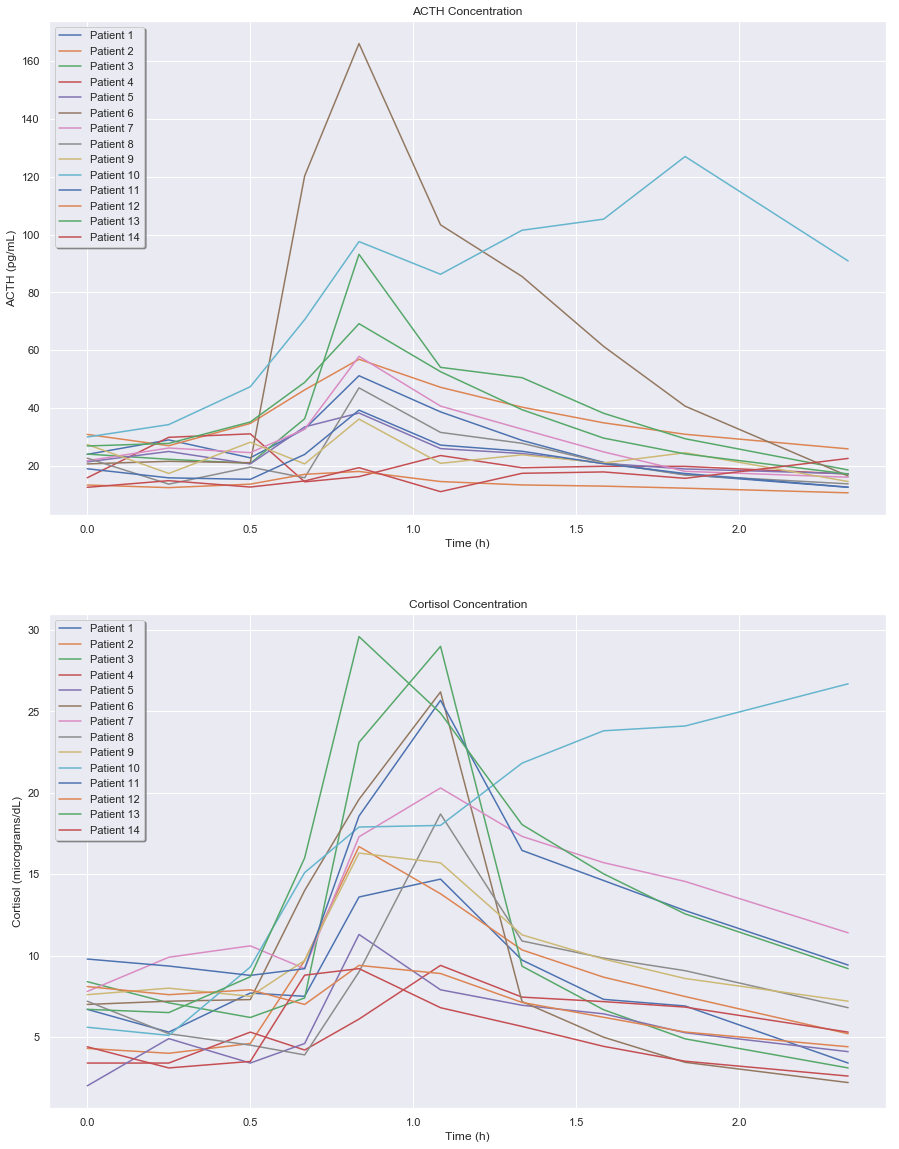

In [26]:
# graph the Nelson data (only showing one patient at a time currently)
matplotlib.rc('font', **{'size'   : 12})

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15,20))

#ax1.plot(nelsonACTH[:,0], nelsonACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,0], label = "Patient 1")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,1], label = "Patient 2")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,2], label = "Patient 3")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,3], label = "Patient 4")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,4], label = "Patient 5")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,5], label = "Patient 6")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,6], label = "Patient 7")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,7], label = "Patient 8")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,8], label = "Patient 9")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,9], label = "Patient 10")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,10], label = "Patient 11")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,11], label = "Patient 12")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,12], label = "Patient 13")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,13], label = "Patient 14")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

#ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,0], label = "Patient 1")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,1], label = "Patient 2")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,2], label = "Patient 3")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,3], label = "Patient 4")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,4], label = "Patient 5")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,5], label = "Patient 6")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,6], label = "Patient 7")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,7], label = "Patient 8")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,8], label = "Patient 9")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,9], label = "Patient 10")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,10], label = "Patient 11")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,11], label = "Patient 12")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,12], label = "Patient 13")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,13], label = "Patient 14")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

In [27]:
# compute means of all patients in each subtype of depression, all control patients, 
# and all subtypes of depression combined

# initialize empty arrays to fill with mean values
nelsonHealthyCortisol_mean = np.zeros(len(nelsonHealthyCortisol[:,0]))
nelsonHealthyACTH_mean = np.zeros(len(nelsonHealthyACTH[:,0]))
nelsonDepressedCortisol_mean = np.zeros(len(nelsonMelancholicCortisol[:,0]))
nelsonDepressedACTH_mean = np.zeros(len(nelsonMelancholicACTH[:,0]))
nelsonMelancholicCortisol_mean = np.zeros(len(nelsonMelancholicCortisol[:,0]))
nelsonMelancholicACTH_mean = np.zeros(len(nelsonMelancholicACTH[:,0]))
nelsonAtypicalCortisol_mean = np.zeros(len(nelsonAtypicalCortisol[:,0]))
nelsonAtypicalACTH_mean = np.zeros(len(nelsonAtypicalACTH[:,0]))
nelsonNeitherCortisol_mean = np.zeros(len(nelsonNeitherCortisol[:,0]))
nelsonNeitherACTH_mean = np.zeros(len(nelsonNeitherACTH[:,0]))

# loop through each time step and add the sum of all patients' values at that time step
for i in range(len(nelsonHealthyCortisol[:,0])):
    nelsonHealthyCortisol_mean[i] += np.sum(nelsonHealthyCortisol[i,:])
    nelsonDepressedCortisol_mean[i] += np.sum(nelsonMelancholicCortisol[i,:])
    nelsonMelancholicCortisol_mean[i] += np.sum(nelsonMelancholicCortisol[i,:])
    nelsonDepressedCortisol_mean[i] += np.sum(nelsonAtypicalCortisol[i,:])
    nelsonAtypicalCortisol_mean[i] += np.sum(nelsonAtypicalCortisol[i,:])
    nelsonDepressedCortisol_mean[i] += np.sum(nelsonNeitherCortisol[i,:])
    nelsonNeitherCortisol_mean[i] += np.sum(nelsonNeitherCortisol[i,:])
    
    nelsonHealthyACTH_mean[i] += np.sum(nelsonHealthyACTH[i,:])
    nelsonDepressedACTH_mean[i] += np.sum(nelsonMelancholicACTH[i,:])
    nelsonMelancholicACTH_mean[i] += np.sum(nelsonMelancholicACTH[i,:])
    nelsonDepressedACTH_mean[i] += np.sum(nelsonAtypicalACTH[i,:])
    nelsonAtypicalACTH_mean[i] += np.sum(nelsonAtypicalACTH[i,:])
    nelsonDepressedACTH_mean[i] += np.sum(nelsonNeitherACTH[i,:])
    nelsonNeitherACTH_mean[i] += np.sum(nelsonNeitherACTH[i,:])

# divide by the number of patients for each set to get the mean
nelsonHealthyCortisol_mean = nelsonHealthyCortisol_mean/15
nelsonHealthyACTH_mean = nelsonHealthyACTH_mean/15

nelsonDepressedCortisol_mean = nelsonDepressedCortisol_mean/43
nelsonDepressedACTH_mean = nelsonDepressedACTH_mean/43

nelsonMelancholicCortisol_mean = nelsonMelancholicCortisol_mean/15
nelsonMelancholicACTH_mean = nelsonMelancholicACTH_mean/15

nelsonAtypicalCortisol_mean = nelsonAtypicalCortisol_mean/14
nelsonAtypicalACTH_mean = nelsonAtypicalACTH_mean/14

nelsonNeitherCortisol_mean = nelsonNeitherCortisol_mean/14
nelsonNeitherACTH_mean = nelsonNeitherACTH_mean/14

[Text(0, 0.5, 'Cortisol (micrograms/dL)'),
 Text(0.5, 0, 'Time (h)'),
 Text(0.5, 1.0, 'Cortisol Concentration')]

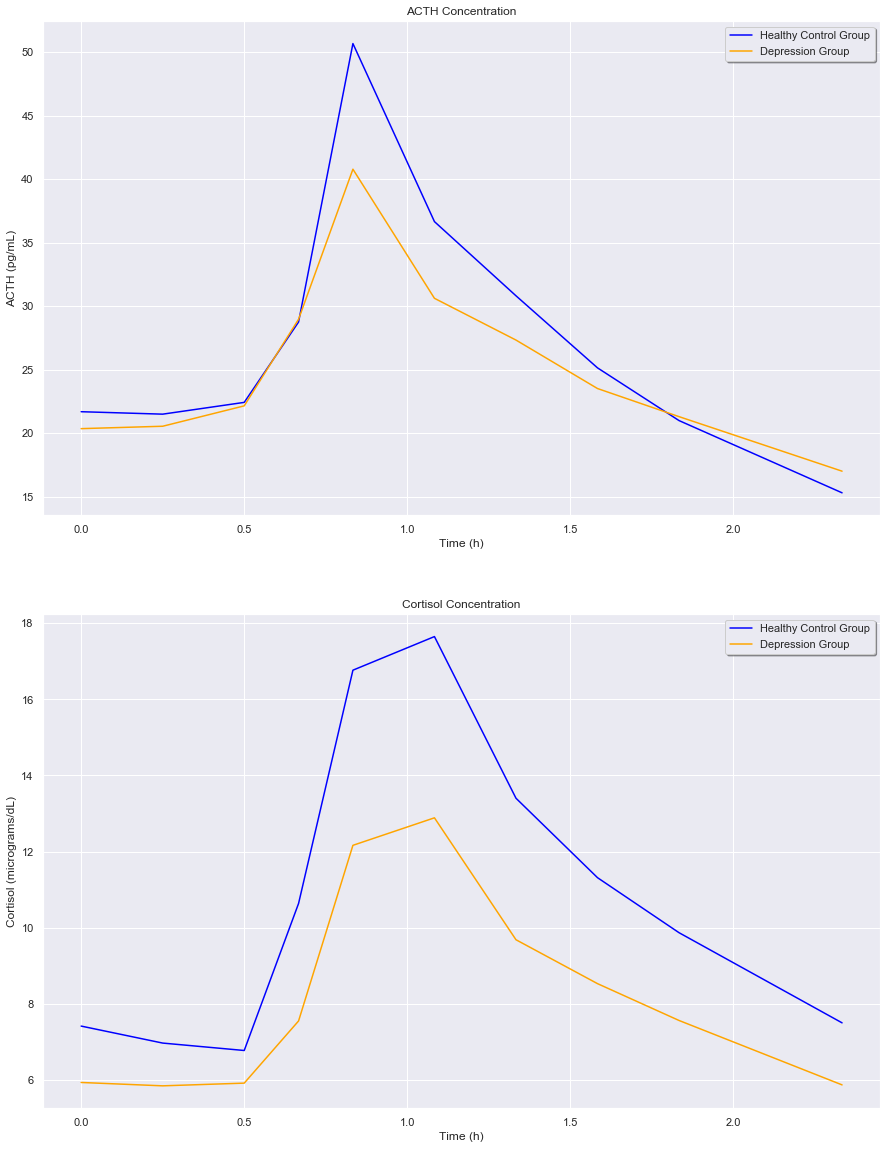

In [28]:
%matplotlib inline

matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15,20))

ax1.plot(nelsonACTH[:,0], nelsonHealthyACTH_mean, label = "Healthy Control Group", color = "blue")
ax1.plot(nelsonACTH[:,0], nelsonDepressedACTH_mean, label = "Depression Group", color = "orange")
ax1.legend(loc = "upper right", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

ax2.plot(nelsonCortisol[:,0], nelsonHealthyCortisol_mean, label = "Healthy Control Group", color = "blue")
ax2.plot(nelsonCortisol[:,0], nelsonDepressedCortisol_mean, label = "Depression Group", color = "orange")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

#plt.savefig("Nelson Data Visualization Figures/nelson-control-vs-depressed-mean-comparison.png", dpi = 300)

[Text(0, 0.5, 'Cortisol (micrograms/dL)'),
 Text(0.5, 0, 'Time (h)'),
 Text(0.5, 1.0, 'Cortisol Concentration')]

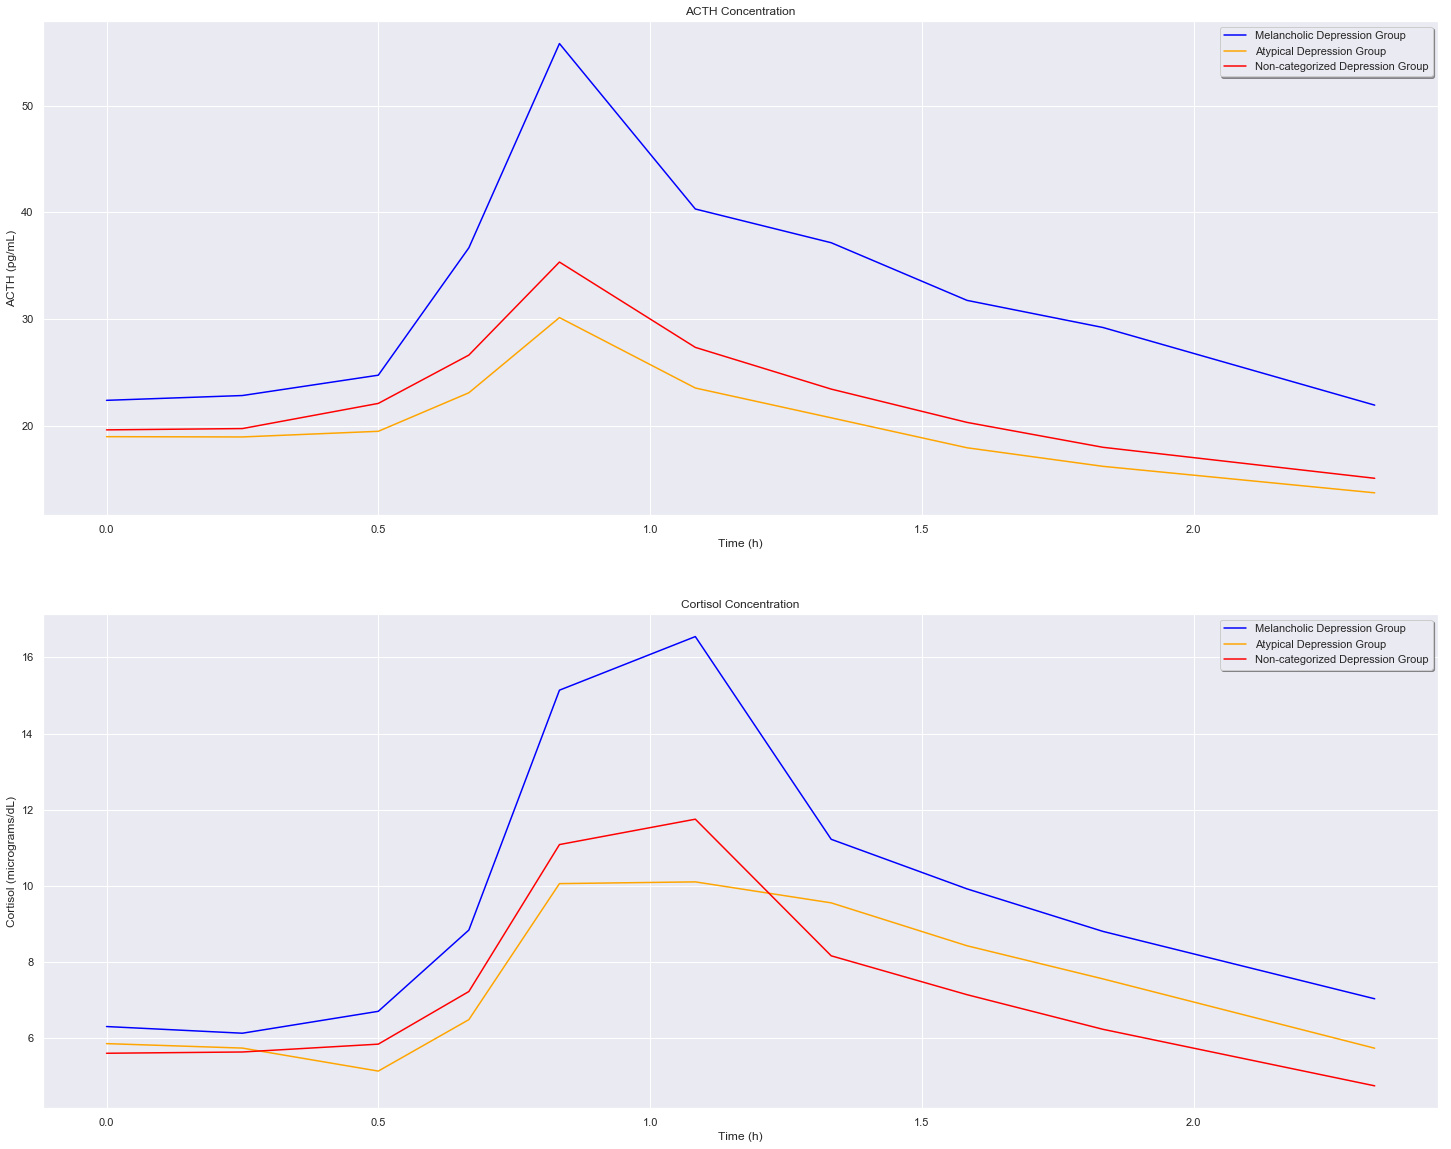

In [29]:
%matplotlib inline

matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (25,20))

ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH_mean, label = "Melancholic Depression Group", color = "blue")
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH_mean, label = "Atypical Depression Group", color = "orange")
ax1.plot(nelsonACTH[:,0], nelsonNeitherACTH_mean, label = "Non-categorized Depression Group", color = "red")
ax1.legend(loc = "upper right", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol_mean, label = "Melancholic Depression Group", color = "blue")
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol_mean, label = "Atypical Depression Group", color = "orange")
ax2.plot(nelsonCortisol[:,0], nelsonNeitherCortisol_mean, label = "Non-categorized Depression Group", color = "red")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

#plt.savefig("Nelson Data Visualization Figures/nelson-depression-subtypes-mean-comparison.png", dpi = 300)

In [30]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


[Text(0, 0.5, 'Cortisol (micrograms/dL)'),
 Text(0.5, 0, 'Time (h)'),
 Text(0.5, 1.0, 'Cortisol Concentration')]

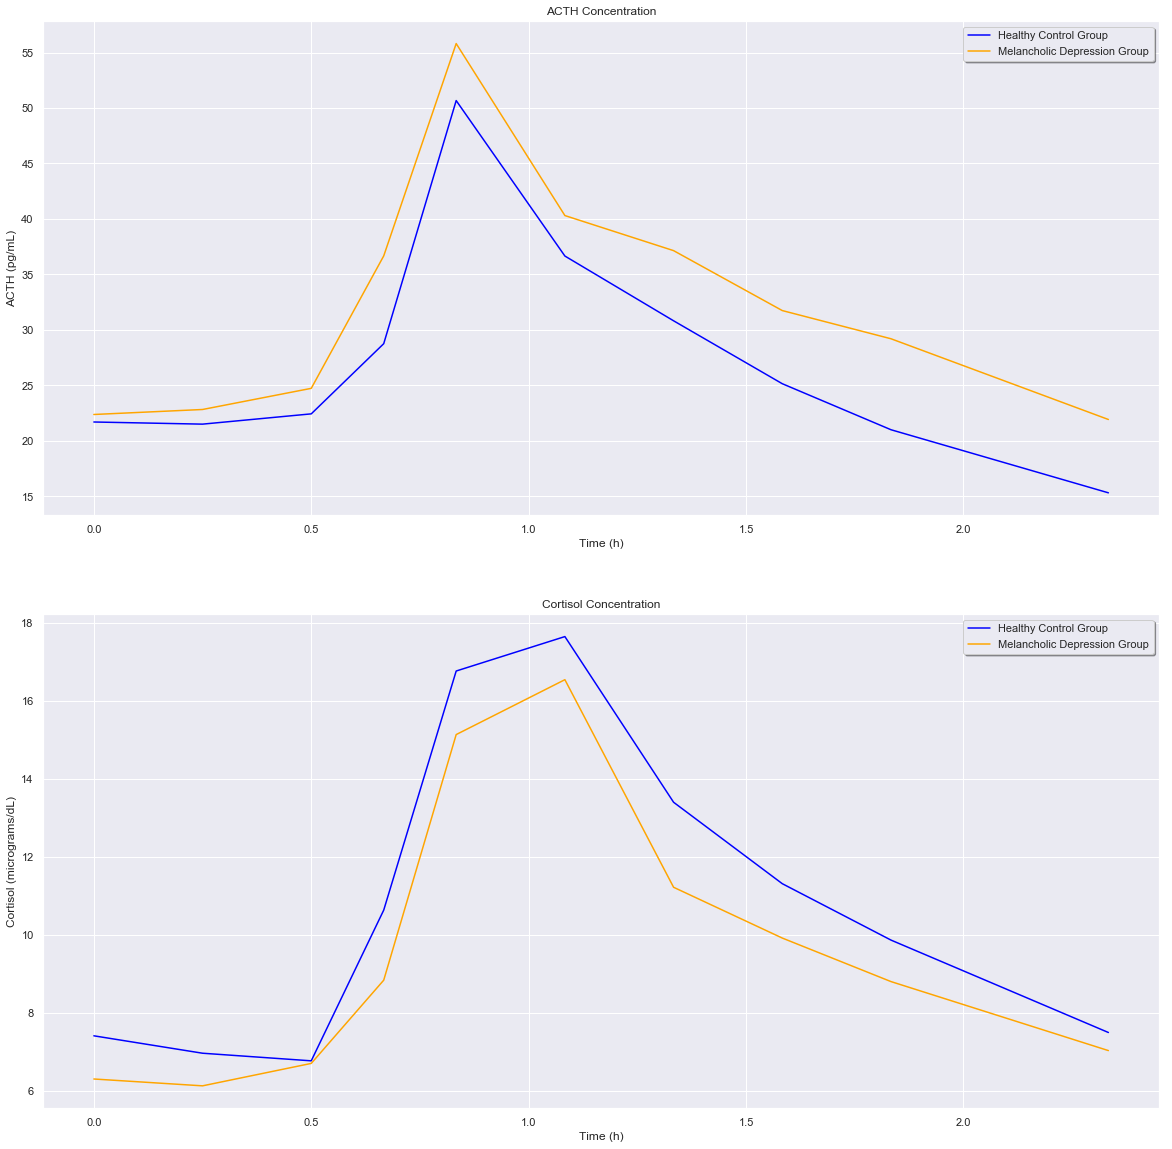

In [31]:
%matplotlib inline

matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (20,20))

ax1.plot(nelsonACTH[:,0], nelsonHealthyACTH_mean, label = "Healthy Control Group", color = "blue")
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH_mean, label = "Melancholic Depression Group", color = "orange")
ax1.legend(loc = "upper right", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

ax2.plot(nelsonCortisol[:,0], nelsonHealthyCortisol_mean, label = "Healthy Control Group", color = "blue")
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol_mean, label = "Melancholic Depression Group", color = "orange")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

#plt.savefig("Nelson Data Visualization Figures/nelson-control-vs-melancholic-depression-mean-comparison.png", dpi = 300)

## Model Function--Includes ODE Solver <a name="modelfunction"></a>

In [32]:
def model(params, ics):
    def ode_system(t, y):
        dy = np.zeros(4)
        # parameters to be optimized including p_stress
        #[k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress] = params
        
        # parameters to be optimized not including p_stress
        [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5] = params
        
        # Change whether we use the stress_input function to add a time-dependent stressor by changing which equation
        #  for dy[0] is not commented
        #dy[0] = stress_input(t)*k_stress*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S3*(y[0]/(K_m1 + y[0])) - K_d1*y[0]
        dy[0] = k_stress*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S3*(y[0]/(K_m1 + y[0])) - K_d1*y[0]
        dy[1] = K_P2*y[0]*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S4*(y[1]/(K_m2 + y[1])) - K_d2*y[1]
        dy[2] = K_P3*y[1] - V_S5*(y[2]/(K_m3 + y[2])) - K_d3*y[2]
        dy[3] = K_b*y[2]*(G_tot - y[3]) + V_S2*(y[3]**n1/(K1**n1 + y[3]**n1)) - K_d5*y[3]

        return dy
    
    def stress_input(t):
        #if (0.5 <= t <= 0.51):
        if (0.5 <= t <= 0.83):
            return p_stress
        else:
            return 1
    
    timeSeries = ODEsolver.solve(ode_system, ics, t_start, t_step, t_end, ode_steps=1000, ode_atol = 1e-8, ode_rtol = 1e-8)
    return timeSeries

## Cost Function Definition <a name="cost"></a>

In [33]:
def cost_fun(params):
    y0 = [params[0], nelsonACTH[0,1], nelsonCortisol[0,1], params[1]]
    simData = model(params[2:], y0)
    
    return costFun.SSE_cost(nelsonACTH[:,0], nelsonACTH[:,1], nelsonCortisol[:,0], nelsonCortisol[:,1], simData)


## Run the Optimization <a name="run"></a>

In [35]:
# it looks, based on the XPP file from the authors, like they start CRH, ACTH, CORT and GR at 0 each and just run
# the solver until they reach some steady state

y0 = [10, nelsonACTH[0,1], nelsonCortisol[0,1], 2]
print(y0)

[10, 20.71677102294828, 6.314796551724138, 2]


In [36]:
# number of times to run the optimization
n = 5

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
# change the number to 237 for Nelson TSST data or 2428 for basal data sets
sims_cort = np.zeros((237, n))
sims_acth = np.zeros((237, n))
sims_crh = np.zeros((237, n))
sims_gr = np.zeros((237, n))

In [35]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, disp = True, popsize = 10)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    y0_tmp = y0
    y0 = [res.x[0], y0_tmp[1], y0_tmp[2], res.x[1]]
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x[2:], y0)
    # save CRH, cortisol and ACTH data into sims arrays
    sims_gr[:,i] = optimizedSimData[:,4]
    sims_cort[:,i] = optimizedSimData[:,3]
    sims_acth[:,i] = optimizedSimData[:,2]
    sims_crh[:,i] = optimizedSimData[:,1]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 0.323766
differential_evolution step 2: f(x)= 0.216781
differential_evolution step 3: f(x)= 0.216781
differential_evolution step 4: f(x)= 0.216781
differential_evolution step 5: f(x)= 0.216781
differential_evolution step 6: f(x)= 0.216781
differential_evolution step 7: f(x)= 0.216781
differential_evolution step 8: f(x)= 0.216781
differential_evolution step 9: f(x)= 0.216781
differential_evolution step 10: f(x)= 0.216781
differential_evolution step 11: f(x)= 0.216781
differential_evolution step 12: f(x)= 0.216781
differential_evolution step 13: f(x)= 0.216781
differential_evolution step 14: f(x)= 0.216781
differential_evolution step 15: f(x)= 0.216781
differential_evolution step 16: f(x)= 0.216781
differential_evolution step 17: f(x)= 0.216781
differential_evolution step 18: f(x)= 0.216781
differential_evolution step 19: f(x)= 0.216781
differential_evolution step 20: f(x)= 0.216781
differential_evolution step 21: f(x)= 0.216781
di

differential_evolution step 174: f(x)= 0.165449
differential_evolution step 175: f(x)= 0.165449
differential_evolution step 176: f(x)= 0.165449
differential_evolution step 177: f(x)= 0.165449
differential_evolution step 178: f(x)= 0.165449
differential_evolution step 179: f(x)= 0.165449
differential_evolution step 180: f(x)= 0.165449
differential_evolution step 181: f(x)= 0.165449
differential_evolution step 182: f(x)= 0.165449
differential_evolution step 183: f(x)= 0.165449
differential_evolution step 184: f(x)= 0.165449
differential_evolution step 185: f(x)= 0.165449
differential_evolution step 186: f(x)= 0.162793
differential_evolution step 187: f(x)= 0.162793
differential_evolution step 188: f(x)= 0.162793
differential_evolution step 189: f(x)= 0.162793
differential_evolution step 190: f(x)= 0.162793
differential_evolution step 191: f(x)= 0.162793
differential_evolution step 192: f(x)= 0.162793
differential_evolution step 193: f(x)= 0.162793
differential_evolution step 194: f(x)= 0

differential_evolution step 345: f(x)= 0.154329
differential_evolution step 346: f(x)= 0.154329
differential_evolution step 347: f(x)= 0.154329
differential_evolution step 348: f(x)= 0.154329
differential_evolution step 349: f(x)= 0.154329
differential_evolution step 350: f(x)= 0.154329
differential_evolution step 351: f(x)= 0.154329
differential_evolution step 352: f(x)= 0.154329
differential_evolution step 353: f(x)= 0.154329
differential_evolution step 354: f(x)= 0.154329
differential_evolution step 355: f(x)= 0.154329
differential_evolution step 356: f(x)= 0.154329
differential_evolution step 357: f(x)= 0.154329
differential_evolution step 358: f(x)= 0.154329
differential_evolution step 359: f(x)= 0.154329
differential_evolution step 360: f(x)= 0.154329
differential_evolution step 361: f(x)= 0.154329
differential_evolution step 362: f(x)= 0.154329
differential_evolution step 363: f(x)= 0.154329
differential_evolution step 364: f(x)= 0.154329
differential_evolution step 365: f(x)= 0

differential_evolution step 516: f(x)= 0.124804
differential_evolution step 517: f(x)= 0.124804
differential_evolution step 518: f(x)= 0.124804
differential_evolution step 519: f(x)= 0.124804
differential_evolution step 520: f(x)= 0.124804
differential_evolution step 521: f(x)= 0.124804
differential_evolution step 522: f(x)= 0.124804
differential_evolution step 523: f(x)= 0.124804
differential_evolution step 524: f(x)= 0.124804
differential_evolution step 525: f(x)= 0.124804
differential_evolution step 526: f(x)= 0.124804
differential_evolution step 527: f(x)= 0.124804
differential_evolution step 528: f(x)= 0.124804
differential_evolution step 529: f(x)= 0.124804
differential_evolution step 530: f(x)= 0.124804
differential_evolution step 531: f(x)= 0.124804
differential_evolution step 532: f(x)= 0.124804
differential_evolution step 533: f(x)= 0.124804
differential_evolution step 534: f(x)= 0.124804
differential_evolution step 535: f(x)= 0.124804
differential_evolution step 536: f(x)= 0

differential_evolution step 687: f(x)= 0.124804
differential_evolution step 688: f(x)= 0.124804
differential_evolution step 689: f(x)= 0.124804
differential_evolution step 690: f(x)= 0.124804
differential_evolution step 691: f(x)= 0.124804
differential_evolution step 692: f(x)= 0.124804
differential_evolution step 693: f(x)= 0.124804
differential_evolution step 694: f(x)= 0.124804
differential_evolution step 695: f(x)= 0.124804
differential_evolution step 696: f(x)= 0.124804
differential_evolution step 697: f(x)= 0.124804
differential_evolution step 698: f(x)= 0.124804
differential_evolution step 699: f(x)= 0.124804
differential_evolution step 700: f(x)= 0.124804
differential_evolution step 701: f(x)= 0.124804
differential_evolution step 702: f(x)= 0.124804
differential_evolution step 703: f(x)= 0.124804
differential_evolution step 704: f(x)= 0.124804
differential_evolution step 705: f(x)= 0.124804
differential_evolution step 706: f(x)= 0.124804
differential_evolution step 707: f(x)= 0

differential_evolution step 858: f(x)= 0.124804
differential_evolution step 859: f(x)= 0.124804
differential_evolution step 860: f(x)= 0.124804
differential_evolution step 861: f(x)= 0.124804
differential_evolution step 862: f(x)= 0.124804
differential_evolution step 863: f(x)= 0.124804
differential_evolution step 864: f(x)= 0.124804
differential_evolution step 865: f(x)= 0.124804
differential_evolution step 866: f(x)= 0.124804
differential_evolution step 867: f(x)= 0.124804
differential_evolution step 868: f(x)= 0.124804
differential_evolution step 869: f(x)= 0.124804
differential_evolution step 870: f(x)= 0.124804
differential_evolution step 871: f(x)= 0.124804
differential_evolution step 872: f(x)= 0.124804
differential_evolution step 873: f(x)= 0.124804
differential_evolution step 874: f(x)= 0.124804
differential_evolution step 875: f(x)= 0.124804
differential_evolution step 876: f(x)= 0.124804
differential_evolution step 877: f(x)= 0.124804
differential_evolution step 878: f(x)= 0

differential_evolution step 31: f(x)= 0.18537
differential_evolution step 32: f(x)= 0.18537
differential_evolution step 33: f(x)= 0.18537
differential_evolution step 34: f(x)= 0.18537
differential_evolution step 35: f(x)= 0.18537
differential_evolution step 36: f(x)= 0.18537
differential_evolution step 37: f(x)= 0.18537
differential_evolution step 38: f(x)= 0.181148
differential_evolution step 39: f(x)= 0.181148
differential_evolution step 40: f(x)= 0.181148
differential_evolution step 41: f(x)= 0.181148
differential_evolution step 42: f(x)= 0.181148
differential_evolution step 43: f(x)= 0.181148
differential_evolution step 44: f(x)= 0.181148
differential_evolution step 45: f(x)= 0.181148
differential_evolution step 46: f(x)= 0.179292
differential_evolution step 47: f(x)= 0.179292
differential_evolution step 48: f(x)= 0.179292
differential_evolution step 49: f(x)= 0.179292
differential_evolution step 50: f(x)= 0.179292
differential_evolution step 51: f(x)= 0.179292
differential_evoluti

differential_evolution step 204: f(x)= 0.143439
differential_evolution step 205: f(x)= 0.143439
differential_evolution step 206: f(x)= 0.143439
differential_evolution step 207: f(x)= 0.143439
differential_evolution step 208: f(x)= 0.143439
differential_evolution step 209: f(x)= 0.143439
differential_evolution step 210: f(x)= 0.143439
differential_evolution step 211: f(x)= 0.143439
differential_evolution step 212: f(x)= 0.143439
differential_evolution step 213: f(x)= 0.143439
differential_evolution step 214: f(x)= 0.143439
differential_evolution step 215: f(x)= 0.143439
differential_evolution step 216: f(x)= 0.143439
differential_evolution step 217: f(x)= 0.143439
differential_evolution step 218: f(x)= 0.143439
differential_evolution step 219: f(x)= 0.143439
differential_evolution step 220: f(x)= 0.143439
differential_evolution step 221: f(x)= 0.143439
differential_evolution step 222: f(x)= 0.143439
differential_evolution step 223: f(x)= 0.143439
differential_evolution step 224: f(x)= 0

differential_evolution step 375: f(x)= 0.13761
differential_evolution step 376: f(x)= 0.13761
differential_evolution step 377: f(x)= 0.13761
differential_evolution step 378: f(x)= 0.13761
differential_evolution step 379: f(x)= 0.13761
differential_evolution step 380: f(x)= 0.13761
differential_evolution step 381: f(x)= 0.13761
differential_evolution step 382: f(x)= 0.13761
differential_evolution step 383: f(x)= 0.13761
differential_evolution step 384: f(x)= 0.13761
differential_evolution step 385: f(x)= 0.13761
differential_evolution step 386: f(x)= 0.13761
differential_evolution step 387: f(x)= 0.13761
differential_evolution step 388: f(x)= 0.13761
differential_evolution step 389: f(x)= 0.13761
differential_evolution step 390: f(x)= 0.13761
differential_evolution step 391: f(x)= 0.13761
differential_evolution step 392: f(x)= 0.13761
differential_evolution step 393: f(x)= 0.13761
differential_evolution step 394: f(x)= 0.13761
differential_evolution step 395: f(x)= 0.13761
differential_

differential_evolution step 548: f(x)= 0.129233
differential_evolution step 549: f(x)= 0.129233
differential_evolution step 550: f(x)= 0.129233
differential_evolution step 551: f(x)= 0.129233
differential_evolution step 552: f(x)= 0.129233
differential_evolution step 553: f(x)= 0.129233
differential_evolution step 554: f(x)= 0.129233
differential_evolution step 555: f(x)= 0.129233
differential_evolution step 556: f(x)= 0.129233
differential_evolution step 557: f(x)= 0.129233
differential_evolution step 558: f(x)= 0.129233
differential_evolution step 559: f(x)= 0.129233
differential_evolution step 560: f(x)= 0.129233
differential_evolution step 561: f(x)= 0.129233
differential_evolution step 562: f(x)= 0.129233
differential_evolution step 563: f(x)= 0.129233
differential_evolution step 564: f(x)= 0.129233
differential_evolution step 565: f(x)= 0.129233
differential_evolution step 566: f(x)= 0.129233
differential_evolution step 567: f(x)= 0.129233
differential_evolution step 568: f(x)= 0

differential_evolution step 720: f(x)= 0.124156
differential_evolution step 721: f(x)= 0.124156
differential_evolution step 722: f(x)= 0.124156
differential_evolution step 723: f(x)= 0.124156
differential_evolution step 724: f(x)= 0.124156
differential_evolution step 725: f(x)= 0.124156
differential_evolution step 726: f(x)= 0.124156
differential_evolution step 727: f(x)= 0.124156
differential_evolution step 728: f(x)= 0.124156
differential_evolution step 729: f(x)= 0.124156
differential_evolution step 730: f(x)= 0.124156
differential_evolution step 731: f(x)= 0.124156
differential_evolution step 732: f(x)= 0.121932
differential_evolution step 733: f(x)= 0.121932
differential_evolution step 734: f(x)= 0.121932
differential_evolution step 735: f(x)= 0.121932
differential_evolution step 736: f(x)= 0.121932
differential_evolution step 737: f(x)= 0.121932
differential_evolution step 738: f(x)= 0.121932
differential_evolution step 739: f(x)= 0.121932
differential_evolution step 740: f(x)= 0

differential_evolution step 891: f(x)= 0.121899
differential_evolution step 892: f(x)= 0.121899
differential_evolution step 893: f(x)= 0.121899
differential_evolution step 894: f(x)= 0.121899
differential_evolution step 895: f(x)= 0.121899
differential_evolution step 896: f(x)= 0.121899
differential_evolution step 897: f(x)= 0.121899
differential_evolution step 898: f(x)= 0.121899
differential_evolution step 899: f(x)= 0.121899
differential_evolution step 900: f(x)= 0.121899
differential_evolution step 901: f(x)= 0.121899
differential_evolution step 902: f(x)= 0.121899
differential_evolution step 903: f(x)= 0.121899
differential_evolution step 904: f(x)= 0.121899
differential_evolution step 905: f(x)= 0.121899
differential_evolution step 906: f(x)= 0.121899
differential_evolution step 907: f(x)= 0.121899
differential_evolution step 908: f(x)= 0.121899
differential_evolution step 909: f(x)= 0.121899
differential_evolution step 910: f(x)= 0.121899
differential_evolution step 911: f(x)= 0

differential_evolution step 65: f(x)= 0.165484
differential_evolution step 66: f(x)= 0.165484
differential_evolution step 67: f(x)= 0.165484
differential_evolution step 68: f(x)= 0.165484
differential_evolution step 69: f(x)= 0.165484
differential_evolution step 70: f(x)= 0.165484
differential_evolution step 71: f(x)= 0.165484
differential_evolution step 72: f(x)= 0.165484
differential_evolution step 73: f(x)= 0.165484
differential_evolution step 74: f(x)= 0.165484
differential_evolution step 75: f(x)= 0.165484
differential_evolution step 76: f(x)= 0.165484
differential_evolution step 77: f(x)= 0.165484
differential_evolution step 78: f(x)= 0.165484
differential_evolution step 79: f(x)= 0.165484
differential_evolution step 80: f(x)= 0.165484
differential_evolution step 81: f(x)= 0.165484
differential_evolution step 82: f(x)= 0.155829
differential_evolution step 83: f(x)= 0.155829
differential_evolution step 84: f(x)= 0.155829
differential_evolution step 85: f(x)= 0.155829
differential_

differential_evolution step 239: f(x)= 0.1342
differential_evolution step 240: f(x)= 0.1342
differential_evolution step 241: f(x)= 0.1342
differential_evolution step 242: f(x)= 0.1342
differential_evolution step 243: f(x)= 0.1342
differential_evolution step 244: f(x)= 0.1342
differential_evolution step 245: f(x)= 0.1342
differential_evolution step 246: f(x)= 0.1342
differential_evolution step 247: f(x)= 0.1342
differential_evolution step 248: f(x)= 0.1342
differential_evolution step 249: f(x)= 0.1342
differential_evolution step 250: f(x)= 0.1342
differential_evolution step 251: f(x)= 0.1342
differential_evolution step 252: f(x)= 0.1342
differential_evolution step 253: f(x)= 0.1342
differential_evolution step 254: f(x)= 0.1342
differential_evolution step 255: f(x)= 0.1342
differential_evolution step 256: f(x)= 0.1342
differential_evolution step 257: f(x)= 0.1342
differential_evolution step 258: f(x)= 0.1342
differential_evolution step 259: f(x)= 0.1342
differential_evolution step 260: f

differential_evolution step 418: f(x)= 0.1342
differential_evolution step 419: f(x)= 0.1342
differential_evolution step 420: f(x)= 0.1342
differential_evolution step 421: f(x)= 0.1342
differential_evolution step 422: f(x)= 0.1342
differential_evolution step 423: f(x)= 0.1342
differential_evolution step 424: f(x)= 0.1342
differential_evolution step 425: f(x)= 0.1342
differential_evolution step 426: f(x)= 0.1342
differential_evolution step 427: f(x)= 0.1342
differential_evolution step 428: f(x)= 0.1342
differential_evolution step 429: f(x)= 0.1342
differential_evolution step 430: f(x)= 0.1342
differential_evolution step 431: f(x)= 0.1342
differential_evolution step 432: f(x)= 0.1342
differential_evolution step 433: f(x)= 0.1342
differential_evolution step 434: f(x)= 0.1342
differential_evolution step 435: f(x)= 0.1342
differential_evolution step 436: f(x)= 0.1342
differential_evolution step 437: f(x)= 0.1342
differential_evolution step 438: f(x)= 0.1342
differential_evolution step 439: f

differential_evolution step 593: f(x)= 0.105251
differential_evolution step 594: f(x)= 0.105251
differential_evolution step 595: f(x)= 0.105251
differential_evolution step 596: f(x)= 0.105251
differential_evolution step 597: f(x)= 0.105251
differential_evolution step 598: f(x)= 0.105251
differential_evolution step 599: f(x)= 0.105251
differential_evolution step 600: f(x)= 0.105251
differential_evolution step 601: f(x)= 0.105251
differential_evolution step 602: f(x)= 0.105251
differential_evolution step 603: f(x)= 0.105251
differential_evolution step 604: f(x)= 0.105251
differential_evolution step 605: f(x)= 0.105251
differential_evolution step 606: f(x)= 0.105251
differential_evolution step 607: f(x)= 0.105251
differential_evolution step 608: f(x)= 0.105251
differential_evolution step 609: f(x)= 0.105251
differential_evolution step 610: f(x)= 0.105251
differential_evolution step 611: f(x)= 0.105251
differential_evolution step 612: f(x)= 0.105251
differential_evolution step 613: f(x)= 0

differential_evolution step 764: f(x)= 0.093141
differential_evolution step 765: f(x)= 0.093141
differential_evolution step 766: f(x)= 0.093141
differential_evolution step 767: f(x)= 0.093141
differential_evolution step 768: f(x)= 0.093141
differential_evolution step 769: f(x)= 0.093141
differential_evolution step 770: f(x)= 0.093141
differential_evolution step 771: f(x)= 0.093141
differential_evolution step 772: f(x)= 0.093141
differential_evolution step 773: f(x)= 0.093141
differential_evolution step 774: f(x)= 0.093141
differential_evolution step 775: f(x)= 0.093141
differential_evolution step 776: f(x)= 0.093141
differential_evolution step 777: f(x)= 0.093141
differential_evolution step 778: f(x)= 0.093141
differential_evolution step 779: f(x)= 0.093141
differential_evolution step 780: f(x)= 0.093141
differential_evolution step 781: f(x)= 0.093141
differential_evolution step 782: f(x)= 0.093141
differential_evolution step 783: f(x)= 0.093141
differential_evolution step 784: f(x)= 0

differential_evolution step 935: f(x)= 0.0862034
differential_evolution step 936: f(x)= 0.0862034
differential_evolution step 937: f(x)= 0.0862034
differential_evolution step 938: f(x)= 0.0862034
differential_evolution step 939: f(x)= 0.0862034
differential_evolution step 940: f(x)= 0.0862034
differential_evolution step 941: f(x)= 0.0862034
differential_evolution step 942: f(x)= 0.0862034
differential_evolution step 943: f(x)= 0.0862034
differential_evolution step 944: f(x)= 0.0862034
differential_evolution step 945: f(x)= 0.0862034
differential_evolution step 946: f(x)= 0.0862034
differential_evolution step 947: f(x)= 0.0862034
differential_evolution step 948: f(x)= 0.0862034
differential_evolution step 949: f(x)= 0.0862034
differential_evolution step 950: f(x)= 0.0862034
differential_evolution step 951: f(x)= 0.0862034
differential_evolution step 952: f(x)= 0.0862034
differential_evolution step 953: f(x)= 0.0862034
differential_evolution step 954: f(x)= 0.0862034
differential_evoluti

differential_evolution step 107: f(x)= 0.170016
differential_evolution step 108: f(x)= 0.170016
differential_evolution step 109: f(x)= 0.170016
differential_evolution step 110: f(x)= 0.170016
differential_evolution step 111: f(x)= 0.170016
differential_evolution step 112: f(x)= 0.170016
differential_evolution step 113: f(x)= 0.170016
differential_evolution step 114: f(x)= 0.170016
differential_evolution step 115: f(x)= 0.158934
differential_evolution step 116: f(x)= 0.158934
differential_evolution step 117: f(x)= 0.158934
differential_evolution step 118: f(x)= 0.158934
differential_evolution step 119: f(x)= 0.158934
differential_evolution step 120: f(x)= 0.158934
differential_evolution step 121: f(x)= 0.158934
differential_evolution step 122: f(x)= 0.158934
differential_evolution step 123: f(x)= 0.158934
differential_evolution step 124: f(x)= 0.158934
differential_evolution step 125: f(x)= 0.158934
differential_evolution step 126: f(x)= 0.158934
differential_evolution step 127: f(x)= 0

differential_evolution step 279: f(x)= 0.150727
differential_evolution step 280: f(x)= 0.150727
differential_evolution step 281: f(x)= 0.150727
differential_evolution step 282: f(x)= 0.150727
differential_evolution step 283: f(x)= 0.150727
differential_evolution step 284: f(x)= 0.150727
differential_evolution step 285: f(x)= 0.150727
differential_evolution step 286: f(x)= 0.150727
differential_evolution step 287: f(x)= 0.150727
differential_evolution step 288: f(x)= 0.150727
differential_evolution step 289: f(x)= 0.150727
differential_evolution step 290: f(x)= 0.150727
differential_evolution step 291: f(x)= 0.150727
differential_evolution step 292: f(x)= 0.150727
differential_evolution step 293: f(x)= 0.150727
differential_evolution step 294: f(x)= 0.150727
differential_evolution step 295: f(x)= 0.150727
differential_evolution step 296: f(x)= 0.150727
differential_evolution step 297: f(x)= 0.150727
differential_evolution step 298: f(x)= 0.150727
differential_evolution step 299: f(x)= 0

differential_evolution step 450: f(x)= 0.144692
differential_evolution step 451: f(x)= 0.144692
differential_evolution step 452: f(x)= 0.144692
differential_evolution step 453: f(x)= 0.144692
differential_evolution step 454: f(x)= 0.144692
differential_evolution step 455: f(x)= 0.144692
differential_evolution step 456: f(x)= 0.144692
differential_evolution step 457: f(x)= 0.144692
differential_evolution step 458: f(x)= 0.144692
differential_evolution step 459: f(x)= 0.144692
differential_evolution step 460: f(x)= 0.144692
differential_evolution step 461: f(x)= 0.144692
differential_evolution step 462: f(x)= 0.144692
differential_evolution step 463: f(x)= 0.144692
differential_evolution step 464: f(x)= 0.144692
differential_evolution step 465: f(x)= 0.144692
differential_evolution step 466: f(x)= 0.144692
differential_evolution step 467: f(x)= 0.144692
differential_evolution step 468: f(x)= 0.144692
differential_evolution step 469: f(x)= 0.144692
differential_evolution step 470: f(x)= 0

differential_evolution step 621: f(x)= 0.138074
differential_evolution step 622: f(x)= 0.138074
differential_evolution step 623: f(x)= 0.138074
differential_evolution step 624: f(x)= 0.138074
differential_evolution step 625: f(x)= 0.138074
differential_evolution step 626: f(x)= 0.138074
differential_evolution step 627: f(x)= 0.138074
differential_evolution step 628: f(x)= 0.138074
differential_evolution step 629: f(x)= 0.138074
differential_evolution step 630: f(x)= 0.137554
differential_evolution step 631: f(x)= 0.137554
differential_evolution step 632: f(x)= 0.137554
differential_evolution step 633: f(x)= 0.137554
differential_evolution step 634: f(x)= 0.137554
differential_evolution step 635: f(x)= 0.137554
differential_evolution step 636: f(x)= 0.137554
differential_evolution step 637: f(x)= 0.137554
differential_evolution step 638: f(x)= 0.137554
differential_evolution step 639: f(x)= 0.137554
differential_evolution step 640: f(x)= 0.137554
differential_evolution step 641: f(x)= 0

differential_evolution step 792: f(x)= 0.135255
differential_evolution step 793: f(x)= 0.135255
differential_evolution step 794: f(x)= 0.135255
differential_evolution step 795: f(x)= 0.135255
differential_evolution step 796: f(x)= 0.135255
differential_evolution step 797: f(x)= 0.135255
differential_evolution step 798: f(x)= 0.135255
differential_evolution step 799: f(x)= 0.135255
differential_evolution step 800: f(x)= 0.135255
differential_evolution step 801: f(x)= 0.135255
differential_evolution step 802: f(x)= 0.135255
differential_evolution step 803: f(x)= 0.135255
differential_evolution step 804: f(x)= 0.135255
differential_evolution step 805: f(x)= 0.135255
differential_evolution step 806: f(x)= 0.135255
differential_evolution step 807: f(x)= 0.135255
differential_evolution step 808: f(x)= 0.135255
differential_evolution step 809: f(x)= 0.135255
differential_evolution step 810: f(x)= 0.135255
differential_evolution step 811: f(x)= 0.135255
differential_evolution step 812: f(x)= 0

differential_evolution step 963: f(x)= 0.135255
differential_evolution step 964: f(x)= 0.135255
differential_evolution step 965: f(x)= 0.135255
differential_evolution step 966: f(x)= 0.135255
differential_evolution step 967: f(x)= 0.135255
differential_evolution step 968: f(x)= 0.135255
differential_evolution step 969: f(x)= 0.135255
differential_evolution step 970: f(x)= 0.135255
differential_evolution step 971: f(x)= 0.135255
differential_evolution step 972: f(x)= 0.135255
differential_evolution step 973: f(x)= 0.135255
differential_evolution step 974: f(x)= 0.135255
differential_evolution step 975: f(x)= 0.135255
differential_evolution step 976: f(x)= 0.135255
differential_evolution step 977: f(x)= 0.135255
differential_evolution step 978: f(x)= 0.135255
differential_evolution step 979: f(x)= 0.135255
differential_evolution step 980: f(x)= 0.135255
differential_evolution step 981: f(x)= 0.135255
differential_evolution step 982: f(x)= 0.135255
differential_evolution step 983: f(x)= 0

differential_evolution step 136: f(x)= 0.160004
differential_evolution step 137: f(x)= 0.160004
differential_evolution step 138: f(x)= 0.160004
differential_evolution step 139: f(x)= 0.160004
differential_evolution step 140: f(x)= 0.160004
differential_evolution step 141: f(x)= 0.160004
differential_evolution step 142: f(x)= 0.160004
differential_evolution step 143: f(x)= 0.160004
differential_evolution step 144: f(x)= 0.160004
differential_evolution step 145: f(x)= 0.160004
differential_evolution step 146: f(x)= 0.160004
differential_evolution step 147: f(x)= 0.160004
differential_evolution step 148: f(x)= 0.160004
differential_evolution step 149: f(x)= 0.160004
differential_evolution step 150: f(x)= 0.160004
differential_evolution step 151: f(x)= 0.160004
differential_evolution step 152: f(x)= 0.160004
differential_evolution step 153: f(x)= 0.160004
differential_evolution step 154: f(x)= 0.160004
differential_evolution step 155: f(x)= 0.160004
differential_evolution step 156: f(x)= 0

differential_evolution step 310: f(x)= 0.14762
differential_evolution step 311: f(x)= 0.14762
differential_evolution step 312: f(x)= 0.14762
differential_evolution step 313: f(x)= 0.14762
differential_evolution step 314: f(x)= 0.14762
differential_evolution step 315: f(x)= 0.14762
differential_evolution step 316: f(x)= 0.14762
differential_evolution step 317: f(x)= 0.14762
differential_evolution step 318: f(x)= 0.14762
differential_evolution step 319: f(x)= 0.14762
differential_evolution step 320: f(x)= 0.14762
differential_evolution step 321: f(x)= 0.14762
differential_evolution step 322: f(x)= 0.14762
differential_evolution step 323: f(x)= 0.14762
differential_evolution step 324: f(x)= 0.14762
differential_evolution step 325: f(x)= 0.14762
differential_evolution step 326: f(x)= 0.14762
differential_evolution step 327: f(x)= 0.14762
differential_evolution step 328: f(x)= 0.14762
differential_evolution step 329: f(x)= 0.14762
differential_evolution step 330: f(x)= 0.14762
differential_

differential_evolution step 483: f(x)= 0.135688
differential_evolution step 484: f(x)= 0.135688
differential_evolution step 485: f(x)= 0.135688
differential_evolution step 486: f(x)= 0.135688
differential_evolution step 487: f(x)= 0.135688
differential_evolution step 488: f(x)= 0.135688
differential_evolution step 489: f(x)= 0.135688
differential_evolution step 490: f(x)= 0.135688
differential_evolution step 491: f(x)= 0.135688
differential_evolution step 492: f(x)= 0.135688
differential_evolution step 493: f(x)= 0.135688
differential_evolution step 494: f(x)= 0.135688
differential_evolution step 495: f(x)= 0.135688
differential_evolution step 496: f(x)= 0.135688
differential_evolution step 497: f(x)= 0.135688
differential_evolution step 498: f(x)= 0.135688
differential_evolution step 499: f(x)= 0.135688
differential_evolution step 500: f(x)= 0.135688
differential_evolution step 501: f(x)= 0.135688
differential_evolution step 502: f(x)= 0.135688
differential_evolution step 503: f(x)= 0

differential_evolution step 657: f(x)= 0.10334
differential_evolution step 658: f(x)= 0.10334
differential_evolution step 659: f(x)= 0.10334
differential_evolution step 660: f(x)= 0.10334
differential_evolution step 661: f(x)= 0.10334
differential_evolution step 662: f(x)= 0.10334
differential_evolution step 663: f(x)= 0.10334
differential_evolution step 664: f(x)= 0.10334
differential_evolution step 665: f(x)= 0.10334
differential_evolution step 666: f(x)= 0.10334
differential_evolution step 667: f(x)= 0.10334
differential_evolution step 668: f(x)= 0.10334
differential_evolution step 669: f(x)= 0.10334
differential_evolution step 670: f(x)= 0.10334
differential_evolution step 671: f(x)= 0.10334
differential_evolution step 672: f(x)= 0.10334
differential_evolution step 673: f(x)= 0.10334
differential_evolution step 674: f(x)= 0.10334
differential_evolution step 675: f(x)= 0.10334
differential_evolution step 676: f(x)= 0.10334
differential_evolution step 677: f(x)= 0.10334
differential_

differential_evolution step 830: f(x)= 0.0879643
differential_evolution step 831: f(x)= 0.0879643
differential_evolution step 832: f(x)= 0.0879643
differential_evolution step 833: f(x)= 0.0879643
differential_evolution step 834: f(x)= 0.0879643
differential_evolution step 835: f(x)= 0.0879643
differential_evolution step 836: f(x)= 0.0879643
differential_evolution step 837: f(x)= 0.0879643
differential_evolution step 838: f(x)= 0.0879643
differential_evolution step 839: f(x)= 0.0879643
differential_evolution step 840: f(x)= 0.0879643
differential_evolution step 841: f(x)= 0.0879643
differential_evolution step 842: f(x)= 0.0879643
differential_evolution step 843: f(x)= 0.0879643
differential_evolution step 844: f(x)= 0.0879643
differential_evolution step 845: f(x)= 0.0879643
differential_evolution step 846: f(x)= 0.0879643
differential_evolution step 847: f(x)= 0.0879643
differential_evolution step 848: f(x)= 0.0879643
differential_evolution step 849: f(x)= 0.0879643
differential_evoluti

differential_evolution step 998: f(x)= 0.0835054
differential_evolution step 999: f(x)= 0.0835054
differential_evolution step 1000: f(x)= 0.0835054
CPU times: user 1h 53min 51s, sys: 1min 50s, total: 1h 55min 42s
Wall time: 4h 34min 2s


## Save Output to File <a name="saveoutput"></a>

In [36]:
df_t = pd.DataFrame(optimizedSimData[:,0])
df_gr = pd.DataFrame(sims_gr)
df_cort = pd.DataFrame(sims_cort)
df_acth = pd.DataFrame(sims_acth)
df_crh = pd.DataFrame(sims_crh)

df_t.to_excel(excel_writer = 'sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-timeSteps-5-iterations-popsize20.xlsx')
df_gr.to_excel(excel_writer = 'sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-gr-5-iterations-popsize20.xlsx')
df_cort.to_excel(excel_writer = 'sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-cort-5-iterations-popsize20.xlsx')
df_acth.to_excel(excel_writer = 'sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-acth-5-iterations-popsize20.xlsx')
df_crh.to_excel(excel_writer = 'sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-crh-5-iterations-popsize20.xlsx')


In [37]:
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-opt-pars-5-iterations-popsize20.txt', opt_pars)
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-timeSteps-5-iterations-popsize20.txt', optimizedSimData[:,0])
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-gr-5-iterations-popsize20.txt', sims_gr)
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-crh-5-iterations-popsize20.txt', sims_crh)
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-acth-5-iterations-popsize20.txt', sims_acth)
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-sims-cort-5-iterations-popsize20.txt', sims_cort)
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-initial-conditions-5-iterations-popsize20.txt', y0)
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-bounds-5-iterations-popsize20.txt', bounds)


## Compute Means and Std Devations of Parameters and Output as Table <a name="paramtable"></a>

In [38]:
k_stress_mean = np.mean(opt_pars[:,1])
k_stress_std = np.std(opt_pars[:,1])
k_i_mean = np.mean(opt_pars[:,2])
k_i_std = np.std(opt_pars[:,2])
V_S3_mean = np.mean(opt_pars[:,3])
V_S3_std = np.std(opt_pars[:,3])
K_m1_mean = np.mean(opt_pars[:,4])
K_m1_std = np.std(opt_pars[:,4])
K_P2_mean = np.mean(opt_pars[:,5])
K_P2_std = np.std(opt_pars[:,5])
V_S4_mean = np.mean(opt_pars[:,6])
V_S4_std = np.std(opt_pars[:,6])
K_m2_mean = np.mean(opt_pars[:,7])
K_m2_std = np.std(opt_pars[:,7])
K_P3_mean = np.mean(opt_pars[:,8])
K_P3_std = np.std(opt_pars[:,8])
V_S5_mean = np.mean(opt_pars[:,9])
V_S5_std = np.std(opt_pars[:,9])
K_m3_mean = np.mean(opt_pars[:,10])
K_m3_std = np.std(opt_pars[:,10])
K_d1_mean = np.mean(opt_pars[:,11])
K_d1_std = np.std(opt_pars[:,11])
K_d2_mean = np.mean(opt_pars[:,12])
K_d2_std = np.std(opt_pars[:,12])
K_d3_mean = np.mean(opt_pars[:,13])
K_d3_std = np.std(opt_pars[:,13])
n1_mean = np.mean(opt_pars[:,14])
n1_std = np.std(opt_pars[:,14])
n2_mean = np.mean(opt_pars[:,15])
n2_std = np.std(opt_pars[:,15])
K_b_mean = np.mean(opt_pars[:,16])
K_b_std = np.std(opt_pars[:,16])
G_tot_mean = np.mean(opt_pars[:,17])
G_tot_std = np.std(opt_pars[:,17])
V_S2_mean = np.mean(opt_pars[:,18])
V_S2_std = np.std(opt_pars[:,18])
K1_mean = np.mean(opt_pars[:,19])
K1_std = np.std(opt_pars[:,19])
K_d5_mean = np.mean(opt_pars[:,20])
K_d5_std = np.std(opt_pars[:,20])
#p_stress_mean = np.mean(opt_pars[:,21])
#p_stress_std = np.std(opt_pars[:,21])

In [39]:
#print(tabulate([["k_stress", "%f +- %f" % (k_stress_mean, k_stress_std)], ["k_i", "%f +- %f" % (k_i_mean, k_i_std)], ["V_S3", "%f +- %f" % (V_S3_mean, V_S3_std)], ["K_m1", "%f +- %f" % (K_m1_mean, K_m1_std)], ["K_P2", "%f +- %f" % (K_P2_mean, K_P2_std)], ["V_S4", "%f +- %f" % (V_S4_mean, V_S4_std)], ["K_m2", "%f +- %f" % (K_m2_mean, K_m2_std)], ["K_P3", "%f +- %f" % (K_P3_mean, K_P3_std)], ["V_S5", "%f +- %f" % (V_S5_mean, V_S5_std)], ["K_m3", "%f +- %f" % (K_m3_mean, K_m3_std)], ["K_d1", "%f +- %f" % (K_d1_mean, K_d1_std)], ["K_d2", "%f +- %f" % (K_d2_mean, K_d2_std)], ["K_d3", "%f +- %f" % (K_d3_mean, K_d3_std)], ["n1", "%f +- %f" % (n1_mean, n1_std)], ["n2", "%f +- %f" % (n2_mean, n2_std)], ["K_b", "%f +- %f" % (K_b_mean, K_b_std)], ["G_tot", "%f +- %f" % (G_tot_mean, G_tot_std)], ["V_S2", "%f +- %f" % (V_S2_mean, V_S2_std)], ["K1", "%f +- %f" % (K1_mean, K1_std)], ["K_d5", "%f +- %f" % (K_d5_mean, K_d5_std)], ["p_stress", "%f +- %f" % (p_stress_mean, p_stress_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))
print(tabulate([["k_stress", "%f +- %f" % (k_stress_mean, k_stress_std)], ["k_i", "%f +- %f" % (k_i_mean, k_i_std)], ["V_S3", "%f +- %f" % (V_S3_mean, V_S3_std)], ["K_m1", "%f +- %f" % (K_m1_mean, K_m1_std)], ["K_P2", "%f +- %f" % (K_P2_mean, K_P2_std)], ["V_S4", "%f +- %f" % (V_S4_mean, V_S4_std)], ["K_m2", "%f +- %f" % (K_m2_mean, K_m2_std)], ["K_P3", "%f +- %f" % (K_P3_mean, K_P3_std)], ["V_S5", "%f +- %f" % (V_S5_mean, V_S5_std)], ["K_m3", "%f +- %f" % (K_m3_mean, K_m3_std)], ["K_d1", "%f +- %f" % (K_d1_mean, K_d1_std)], ["K_d2", "%f +- %f" % (K_d2_mean, K_d2_std)], ["K_d3", "%f +- %f" % (K_d3_mean, K_d3_std)], ["n1", "%f +- %f" % (n1_mean, n1_std)], ["n2", "%f +- %f" % (n2_mean, n2_std)], ["K_b", "%f +- %f" % (K_b_mean, K_b_std)], ["G_tot", "%f +- %f" % (G_tot_mean, G_tot_std)], ["V_S2", "%f +- %f" % (V_S2_mean, V_S2_std)], ["K1", "%f +- %f" % (K1_mean, K1_std)], ["K_d5", "%f +- %f" % (K_d5_mean, K_d5_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))


Parameter    Mean +- Standard Deviation
-----------  ----------------------------
k_stress     23.206027 +- 12.517263
k_i          3.636986 +- 3.280808
V_S3         14.948563 +- 9.353983
K_m1         3.307970 +- 1.314864
K_P2         6.112049 +- 2.789587
V_S4         3.543177 +- 3.146848
K_m2         8.345655 +- 8.458182
K_P3         9.447544 +- 0.512119
V_S5         2.892143 +- 1.893482
K_m3         1.412769 +- 0.167585
K_d1         0.062186 +- 0.028846
K_d2         0.230699 +- 0.121547
K_d3         0.055739 +- 0.031730
n1           0.078206 +- 0.014681
n2           4.136958 +- 0.539914
K_b          8.332175 +- 3.358176
G_tot        5.919995 +- 4.116429
V_S2         0.067704 +- 0.082492
K1           22.214100 +- 11.783519
K_d5         3.527992 +- 2.500701


In [40]:
np.savetxt('sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-param-means-stds-5-iterations-popsize20.txt', [k_stress_mean, k_stress_std, k_i_mean, k_i_std, V_S3_mean, V_S3_std, K_m1_mean, K_m1_std, K_P2_mean, K_P2_std, V_S4_mean, V_S4_std, K_m2_mean, K_m2_std, K_P3_mean, K_P3_std, V_S5_mean, V_S5_std, K_m3_mean, K_m3_std, K_d1_mean, K_d1_std, K_d2_mean, K_d2_std, K_d3_mean, K_d3_std, n1_mean, n1_std, n2_mean, n2_std, K_b_mean, K_b_std, G_tot_mean, G_tot_std, V_S2_mean, V_S2_std, K1_mean, K1_std, K_d5_mean, K_d5_std])
#np.savetxt('sriramModel_output/sriramModel-nelson-atypical-patientID_1-param-means-stds-5-iterations-p-stress.txt', [k_stress_mean, k_stress_std, k_i_mean, k_i_std, V_S3_mean, V_S3_std, K_m1_mean, K_m1_std, K_P2_mean, K_P2_std, V_S4_mean, V_S4_std, K_m2_mean, K_m2_std, K_P3_mean, K_P3_std, V_S5_mean, V_S5_std, K_m3_mean, K_m3_std, K_d1_mean, K_d1_std, K_d2_mean, K_d2_std, K_d3_mean, K_d3_std, n1_mean, n1_std, n2_mean, n2_std, K_b_mean, K_b_std, G_tot_mean, G_tot_std, V_S2_mean, V_S2_std, K1_mean, K1_std, K_d5_mean, K_d5_std, p_stress_mean, p_stress_std])


## Plots <a name="plots"></a>

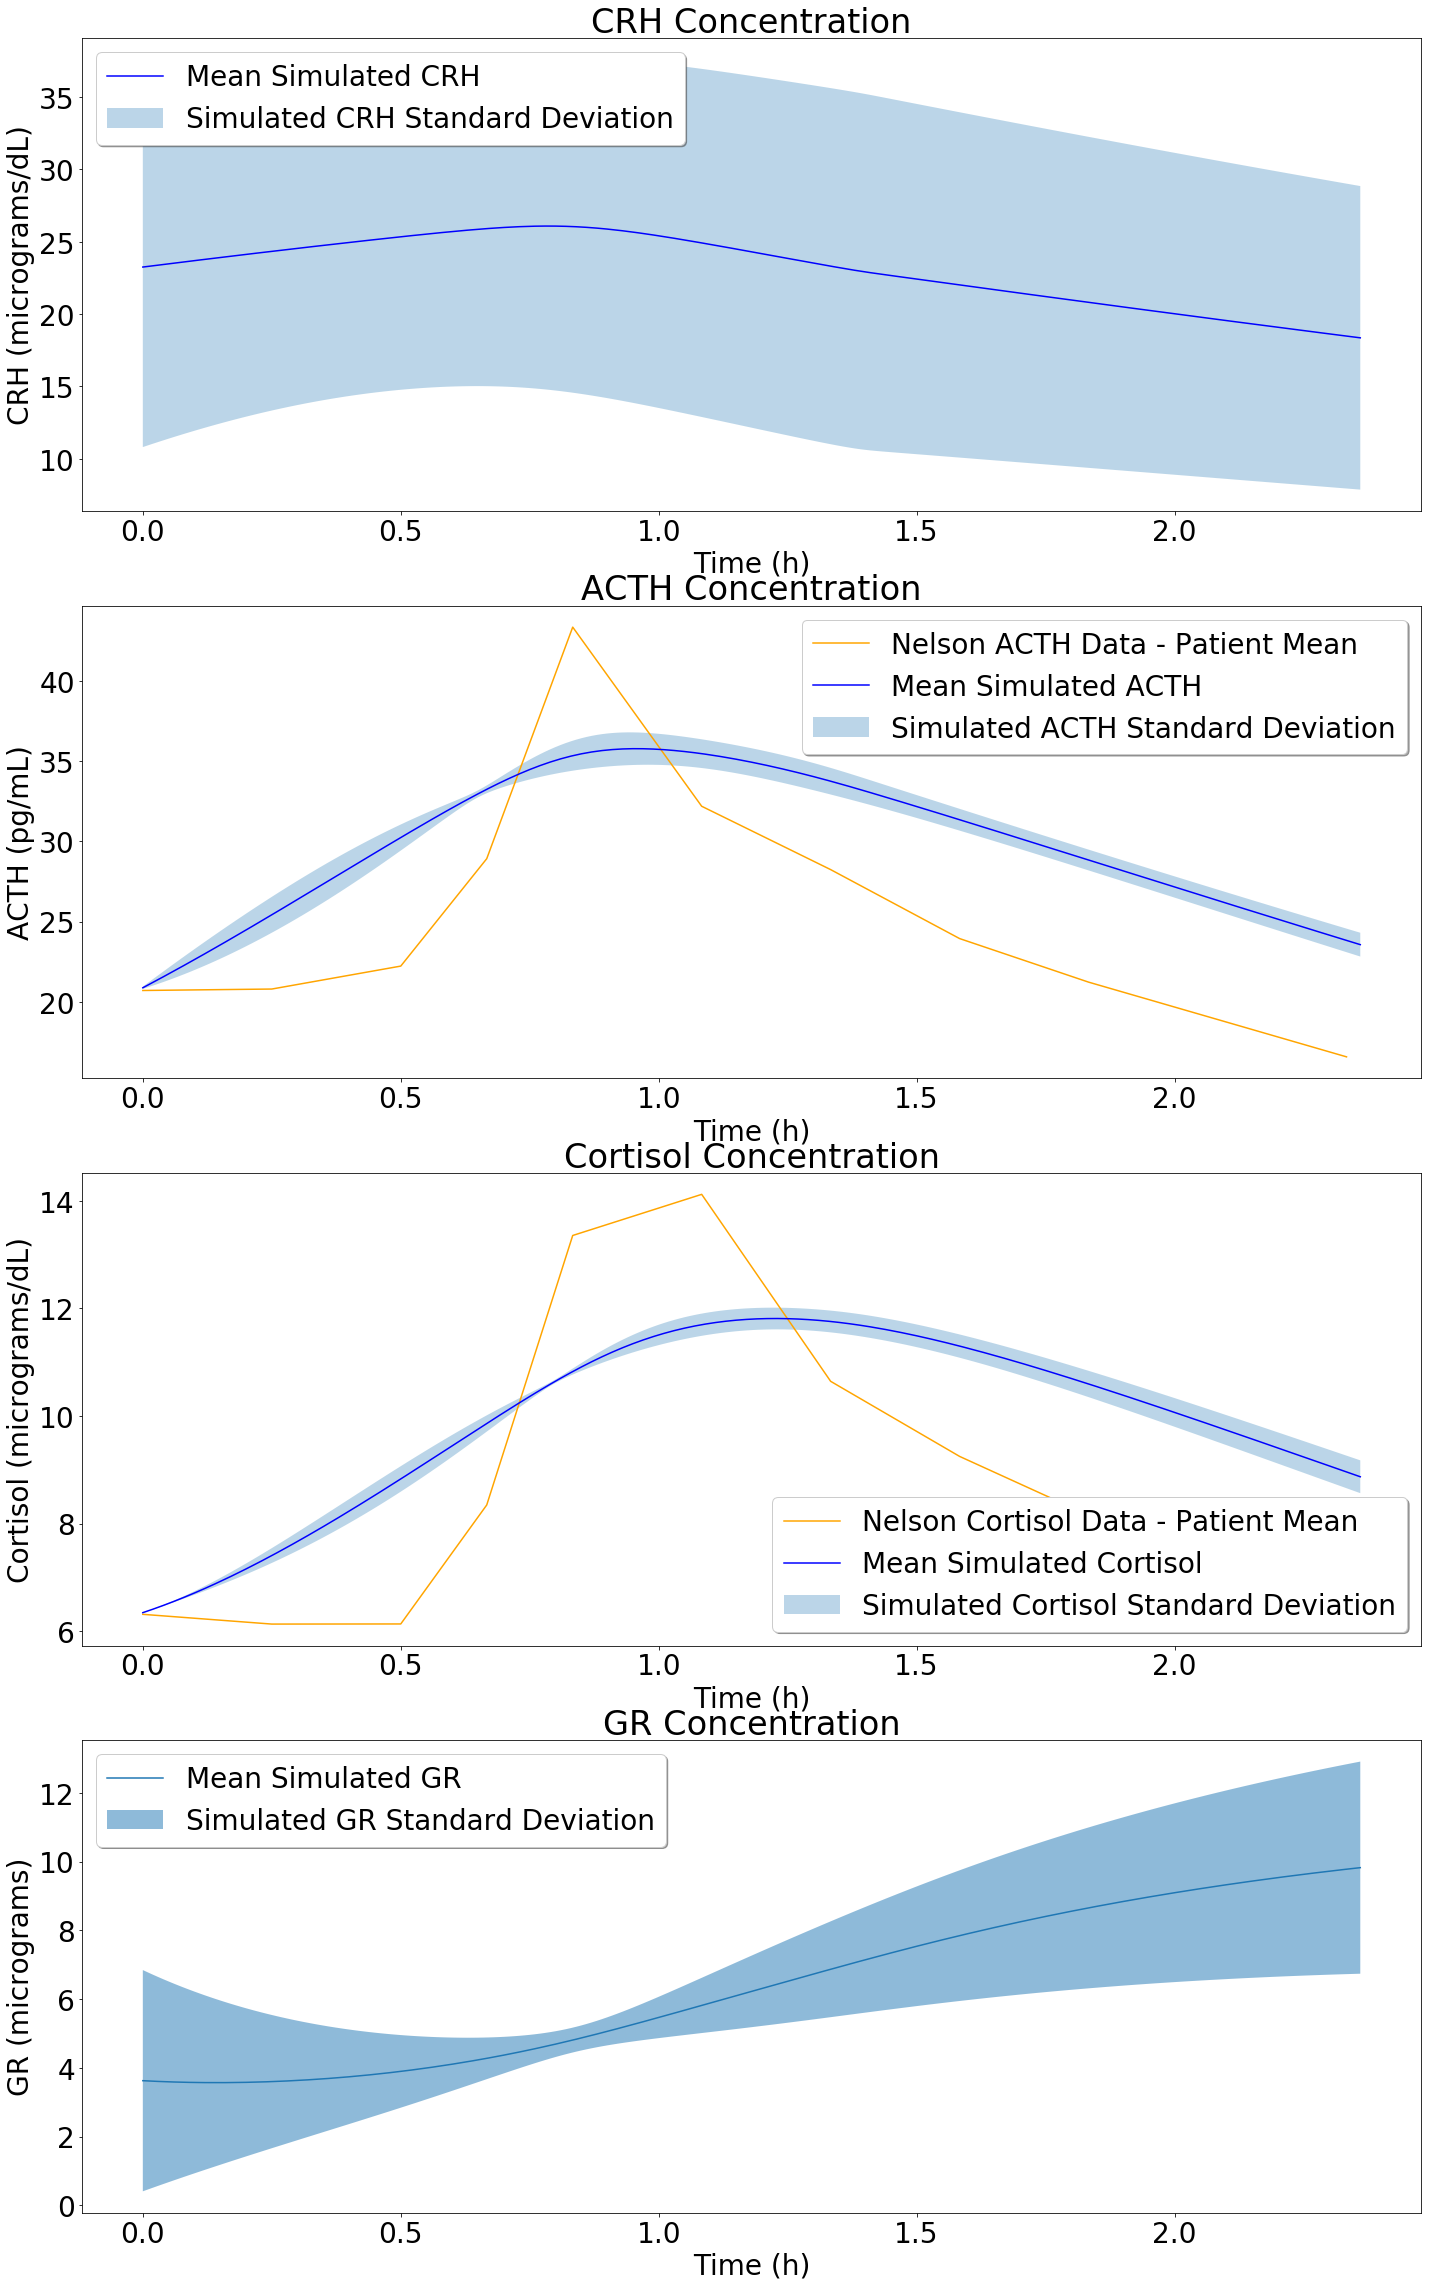

In [41]:
%matplotlib inline
# plot of raw data with simulation data for cortisol, then just simulation data for crh and acth

matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(24,40))

# for only 1 iteration, uncomment below and comment the following line
#ax1.plot(optimizedSimData[:,0], sims_crh, label = "Mean Simulated CRH")
ax1.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Mean Simulated CRH", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "CRH (micrograms/dL)", title = "CRH Concentration")

# change this line when you change which data set you are matching
ax2.plot(nelsonACTH[:,0], nelsonACTH[:,1], label = "Nelson ACTH Data - Patient Mean", color = "orange")

# for only 1 iteration, uncomment below and comment the following line
#ax2.plot(optimizedSimData[:,0], sims_acth, label = "Mean")
ax2.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Mean Simulated ACTH", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

# change this line when you change which data set you are matching
ax3.plot(nelsonCortisol[:,0], nelsonCortisol[:,1], label = "Nelson Cortisol Data - Patient Mean", color = "orange")

# for only 1 iteration, uncomment below and comment the following line
#ax3.plot(optimizedSimData[:,0], sims_cort, label = "Simulation Mean")
ax3.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Mean Simulated Cortisol", color = "blue")
ax3.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "lower right", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

# for only 1 iteration, uncomment below and comment the following line
#ax4.plot(optimizedSimData[:,0], sims_gr, label = "Mean")
ax4.plot(optimizedSimData[:,0], np.mean(sims_gr, axis = 1), label = "Mean Simulated GR")
ax4.fill_between(optimizedSimData[:,0], np.mean(sims_gr, axis = 1) - np.std(sims_gr, axis = 1), np.mean(sims_gr, axis = 1) + np.std(sims_gr, axis = 1), alpha = 0.5, label = "Simulated GR Standard Deviation")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (h)", ylabel = "GR (micrograms)", title = "GR Concentration")

# uncomment the next two lines and enter the cost value range you got to have it reported at the bottom of the figure
#txt = "cost = []"
#plt.figtext(0.1, 0.09, txt, wrap = True, horizontalalignment = 'center', fontsize = 30)

# save the figure to a PNG file
plt.savefig("sriramModel_output/sriramModel-nelson-patientMean-MAX_cost-IC_opt-5-iterations-all-params-normalizedCost-popsize20.png", dpi = 300)


## Figure 3 Reproduction <a name="fig3"></a>

In [66]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 10.1
k_i = 1.51
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params_control = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [67]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 13.7
k_i = 1.6
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params_depressed = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [68]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 17.5
k_i = 1.17
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params_ptsd = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [69]:
y0_control = [1, 5, 5, 2]
y0_depressed = [1, 5, 5, 2]
y0_ptsd = [1, 5, 5, 2]

t_start = -0.01
t_end = 300.01
t_step = 0.01

In [72]:
%%time

no_opt_control = model(authors_params_control, y0_control)
no_opt_depressed = model(authors_params_depressed, y0_depressed)
no_opt_ptsd = model(authors_params_ptsd, y0_ptsd)

sims_gr_control = no_opt_control[:,4]
sims_cort_control = no_opt_control[:,3]
sims_acth_control = no_opt_control[:,2]
sims_crh_control = no_opt_control[:,1]

sims_gr_depressed = no_opt_depressed[:,4]
sims_cort_depressed = no_opt_depressed[:,3]
sims_acth_depressed = no_opt_depressed[:,2]
sims_crh_depressed = no_opt_depressed[:,1]

sims_gr_ptsd = no_opt_ptsd[:,4]
sims_cort_ptsd = no_opt_ptsd[:,3]
sims_acth_ptsd = no_opt_ptsd[:,2]
sims_crh_ptsd = no_opt_ptsd[:,1]

CPU times: user 844 ms, sys: 25.8 ms, total: 870 ms
Wall time: 868 ms


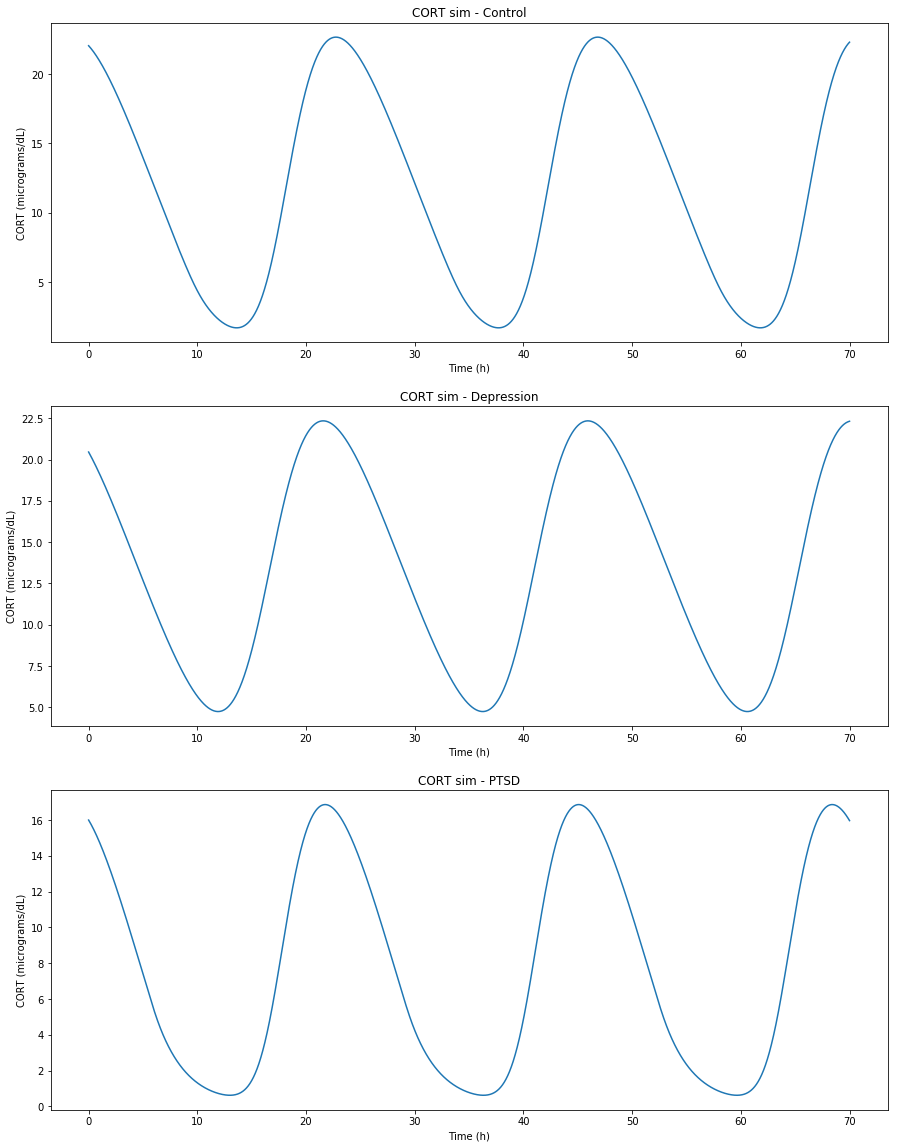

In [73]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,20))

ax1.plot(np.arange(0, 70, 0.01), sims_cort_control[-7800:-800], label = "CORT sim - Control")
ax1.set(ylabel = "CORT (micrograms/dL)", xlabel = "Time (h)", title = "CORT sim - Control")
#ax1.legend(loc = "upper right", shadow = True, fancybox = True)

ax2.plot(np.arange(0, 70, 0.01), sims_cort_depressed[-8800:-1800], label = "CORT sim - Depression")
ax2.set(ylabel = "CORT (micrograms/dL)", xlabel = "Time (h)", title = "CORT sim - Depression")
#ax2.legend(loc = "upper right", shadow = True, fancybox = True)

ax3.plot(np.arange(0, 70, 0.01), sims_cort_ptsd[-9100:-2100], label = "CORT sim - PTSD")
ax3.set(ylabel = "CORT (micrograms/dL)", xlabel = "Time (h)", title = "CORT sim - PTSD")
#ax3.legend(loc = "upper right", shadow = True, fancybox = True)

plt.savefig("sriramModel_output/sriramModel-figure3-reproduction.png", dpi=300)

## Figure 4 Reproduction <a name="fig4"></a>

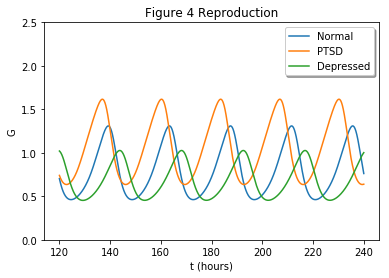

In [74]:
# create Fig 4 of free glucocorticoid receptor level
t_end = 240.01

normal = model(authors_params_control, y0)
PTSD = model(authors_params_ptsd, y0)
depressed = model(authors_params_depressed, y0)

G_normal = G_tot - normal[:,4]
G_PTSD = G_tot - PTSD[:,4]
G_depressed = G_tot - depressed[:,4]

plt.plot(normal[-12000:,0], G_normal[-12000:], label='Normal')
plt.plot(PTSD[-12000:,0], G_PTSD[-12000:], label='PTSD')
plt.plot(depressed[-12000:,0], G_depressed[-12000:], label='Depressed')
plt.ylim(0,2.5)
plt.xlabel('t (hours)')
plt.ylabel('G')
plt.title("Figure 4 Reproduction")
plt.legend(loc = "upper right", shadow = True, fancybox = True)
plt.savefig("sriramModel_output/sriramModel-figure4-reproduction.png", dpi=300)

## Load Parameter Sets, Run Model and Save Hormone Concentration Data <a name="loadparams"></a>

In [58]:
loaded_params = np.genfromtxt("sriram-opt-pars-carrollControl-rearr-1-all-params-expanded-bounds.txt")
y0 = np.genfromtxt("sriram-y0-carrollControl-rearr-1-all-params-expanded-bounds.txt")
bounds = np.genfromtxt("sriram-bounds-carrollControl-rearr-1-all-params-expanded-bounds.txt")

In [59]:
# if loading only a single iteration
loaded_params = loaded_params[1:]

# if loading multiple iterations
#loaded_params = loaded_params[1:,:]

In [ ]:
# alternatively, you can set the parameters yourself in the 
#  Parameters and Initial Conditions section and then 
#  uncomment & run this cell
#loaded_params = authors_params

In [60]:
# plug the optimized parameters into the solver
optimizedSimData = model(loaded_params, y0)
    
# save CRH, cortisol and ACTH data into sims arrays
sims_gr = optimizedSimData[:,4]
sims_cort = optimizedSimData[:,3]
sims_acth = optimizedSimData[:,2]
sims_crh = optimizedSimData[:,1]

### Checking Parameter Sets Generated Externally <a name="checkexternal"></a>

In [98]:
cort_data = np.zeros((2403,len(loaded_params)))
for i in range(len(loaded_params)):
    cort_data[:,i] = np.transpose(np.hstack((i+1,model(loaded_params[i,1:], y0)[:,3])))

In [100]:
time_data = np.zeros((2403,len(loaded_params)))
for i in range(len(loaded_params)):
    time_data[:,i] = np.transpose(np.hstack((i+1,model(loaded_params[i,1:], y0)[:,0])))

In [102]:
np.savetxt("sriram-cort-data-yehudaControl-1000-all-params.txt", cort_data)

In [103]:
np.savetxt("sriram-time-data-yehudaControl-1000-all-params.txt", time_data)

In [725]:
sim = model(yin_params[next_max,1:], y0)

In [814]:
sim = model(testing_params, y0)

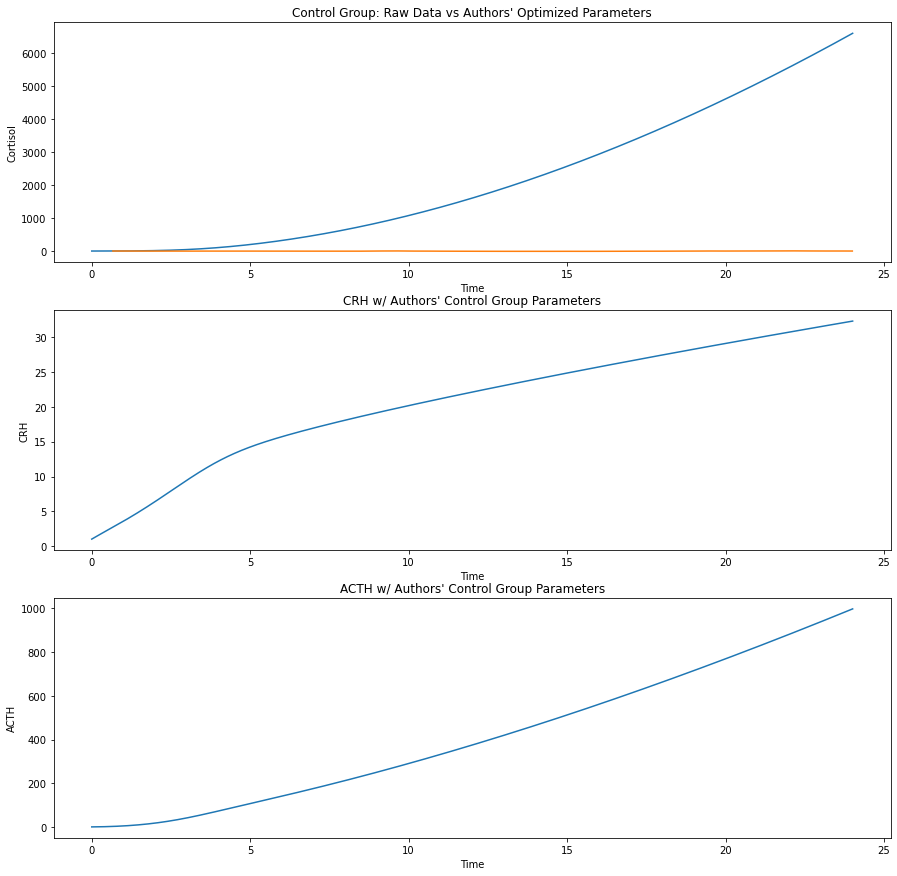

In [816]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))
ax1.plot(sim[:,0], sim[:,3], label = "Simulation")
ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Yehuda Control Group")
ax1.set(xlabel = "Time", ylabel = "Cortisol", title = "Control Group: Raw Data vs Authors' Optimized Parameters")
ax2.plot(sim[:,0], sim[:,1])
ax2.set(xlabel = "Time", ylabel = "CRH", title = "CRH w/ Authors' Control Group Parameters")
ax3.plot(sim[:,0], sim[:,2])
ax3.set(xlabel = "Time", ylabel = "ACTH", title = "ACTH w/ Authors' Control Group Parameters")

plt.savefig("testing-params-kb-0.01.pdf", dpi = 300)

## Load Simulated Concentration Data from Files and Plot <a name="load-and-plot"></a>

In [456]:
sims_t = np.genfromtxt('sriramModel_output/sriramModel-nelson-atypical-patientID_19-timeSteps-5-iterations.txt')
sims_gr = np.genfromtxt('sriramModel_output/sriramModel-nelson-atypical-patientID_19-sims-gr-5-iterations.txt')
sims_cort = np.genfromtxt('sriramModel_output/sriramModel-nelson-atypical-patientID_19-sims-cort-5-iterations.txt')
sims_crh = np.genfromtxt('sriramModel_output/sriramModel-nelson-atypical-patientID_19-sims-crh-5-iterations.txt')
sims_acth = np.genfromtxt('sriramModel_output/sriramModel-nelson-atypical-patientID_19-sims-acth-5-iterations.txt')

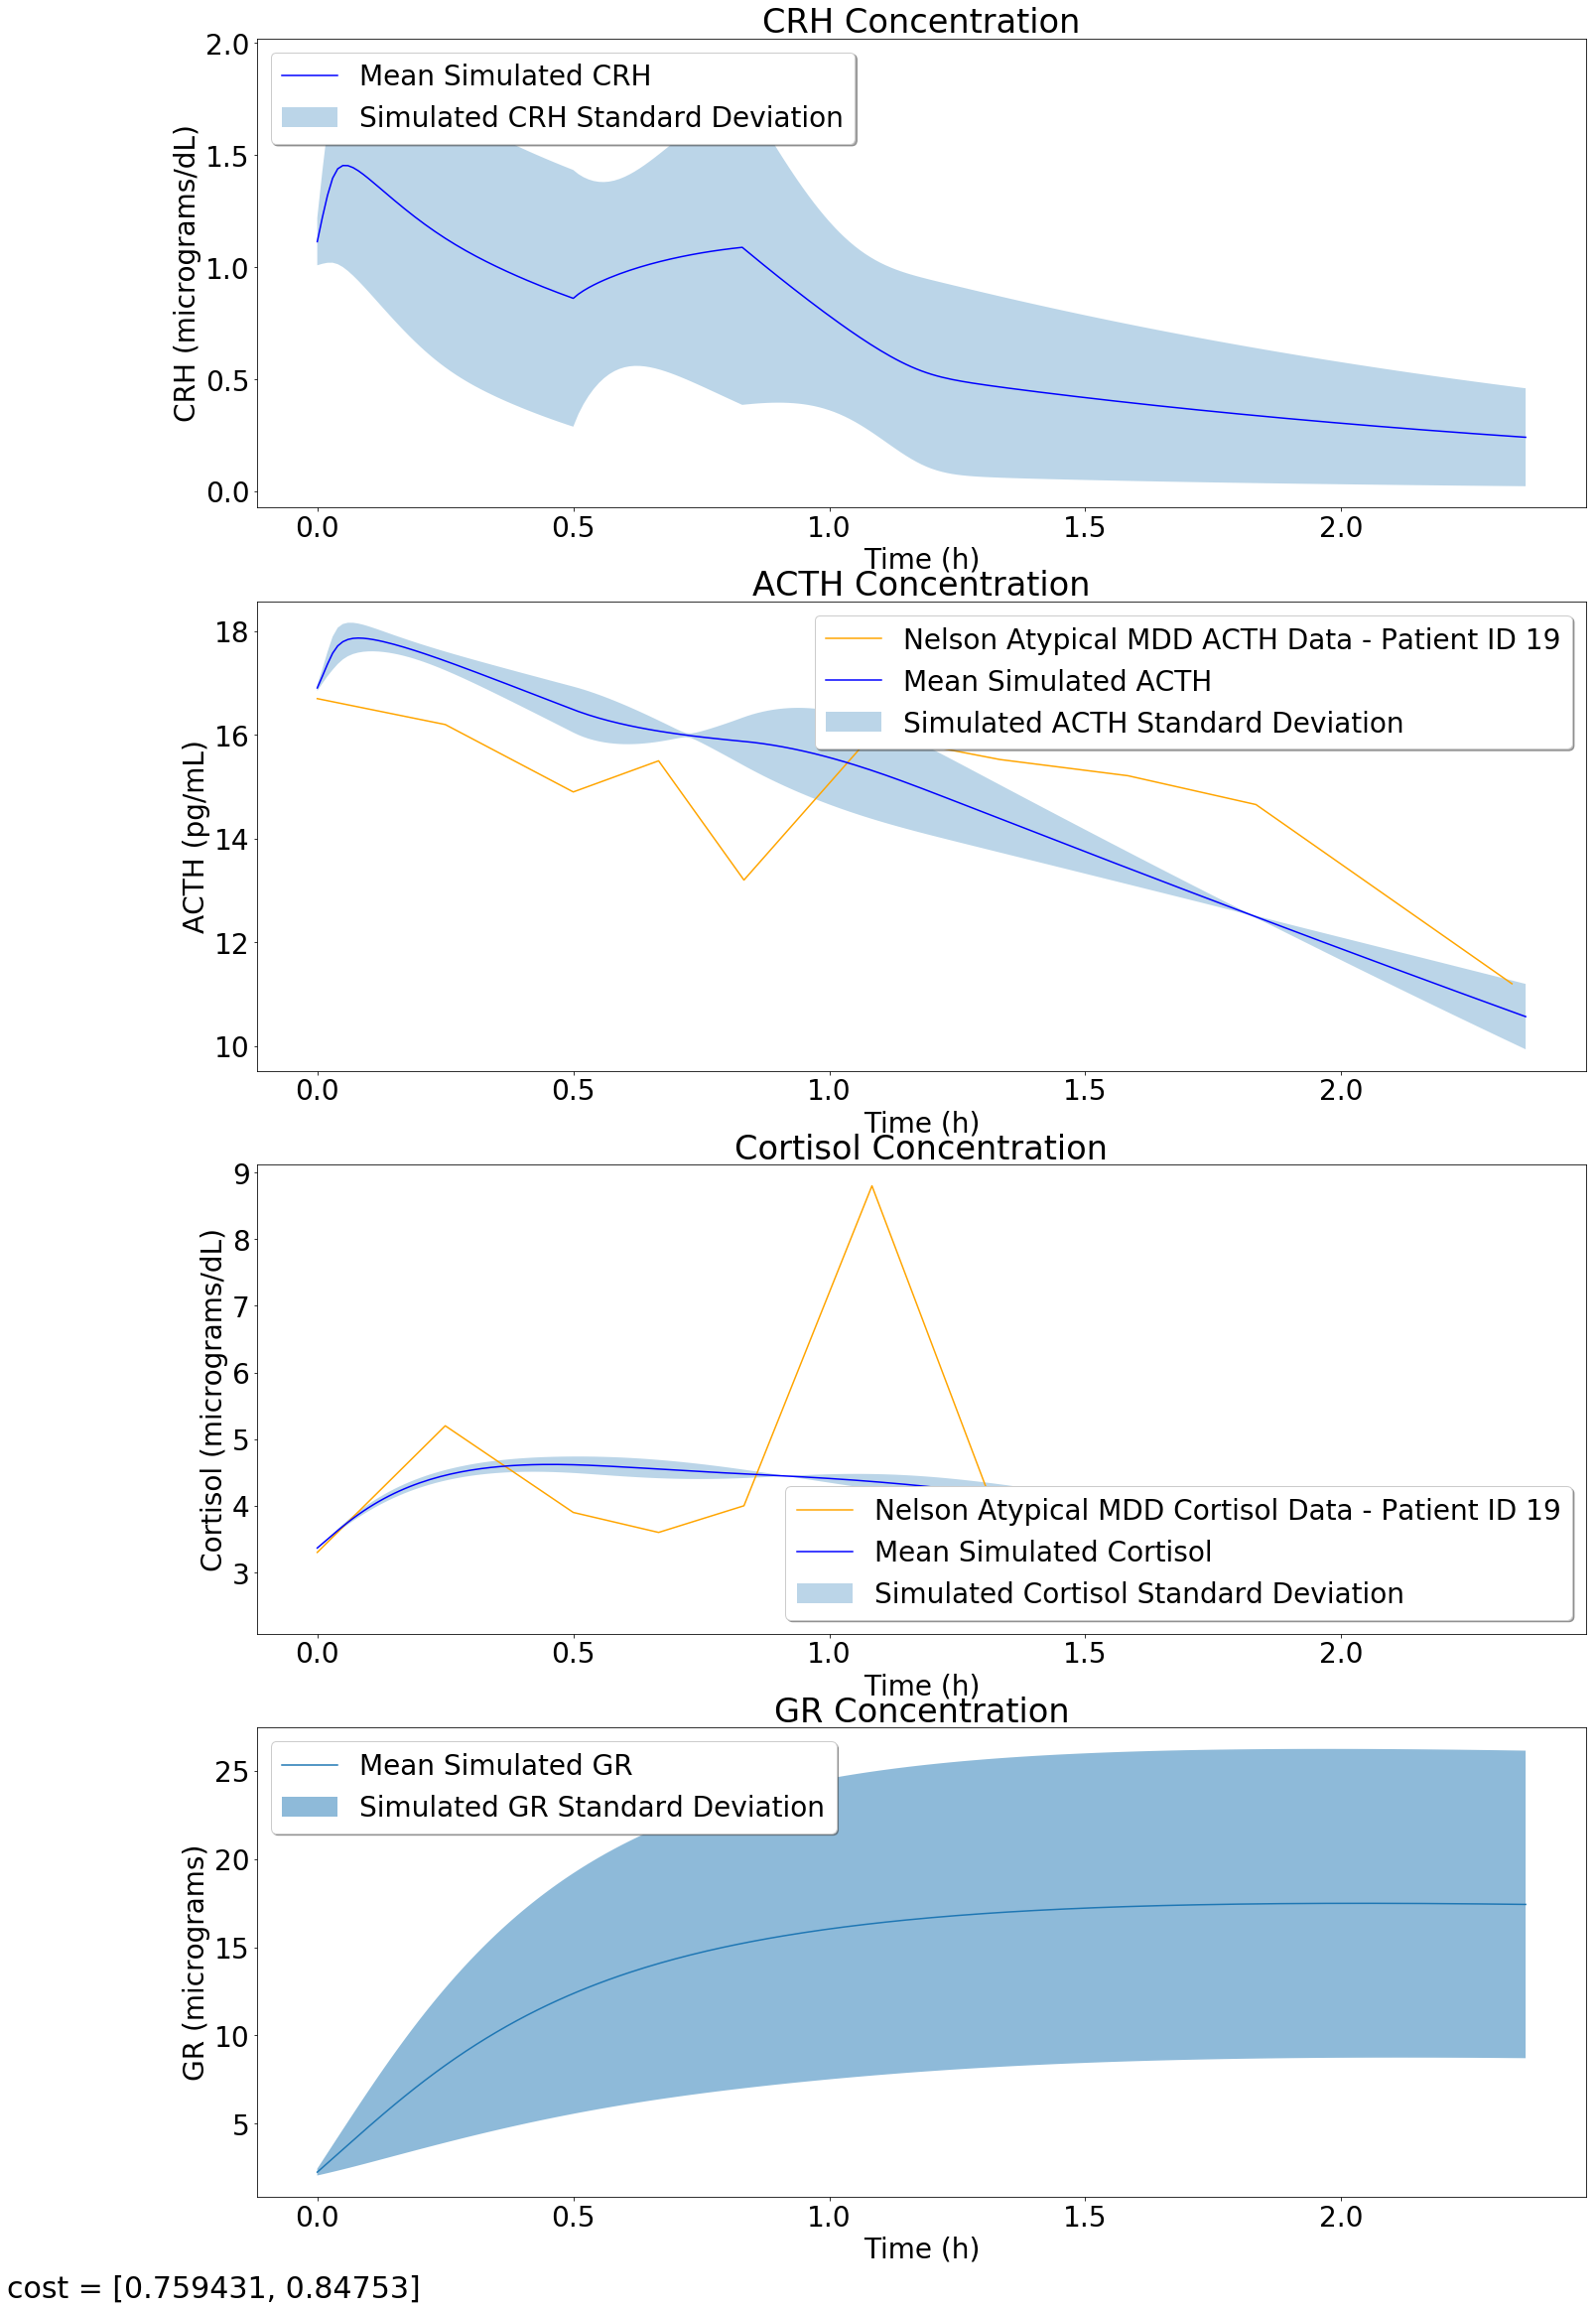

In [457]:
%matplotlib inline
# plot of raw data with simulation data for cortisol, then just simulation data for crh and acth

matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(24,40))

#ax1.plot(optimizedSimData[:,0], sims_crh, label = "Mean Simulated CRH")
# for more than 1 iteration, uncomment below
ax1.plot(sims_t, np.mean(sims_crh, axis = 1), label = "Mean Simulated CRH", color = "blue")
ax1.fill_between(sims_t, np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "CRH (micrograms/dL)", title = "CRH Concentration")

#ax2.plot(optimizedSimData[:,0], sims_acth, label = "Mean")
ax2.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,5], label = "Nelson Atypical MDD ACTH Data - Patient ID 19", color = "orange")
# for more than 1 iteration, uncomment below
ax2.plot(sims_t, np.mean(sims_acth, axis = 1), label = "Mean Simulated ACTH", color = "blue")
ax2.fill_between(sims_t, np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

#ax3.plot(optimizedSimData[:,0], sims_cort, label = "Simulation Mean")
ax3.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,5], label = "Nelson Atypical MDD Cortisol Data - Patient ID 19", color = "orange")
# for more than 1 iteration, uncomment below
ax3.plot(sims_t, np.mean(sims_cort, axis = 1), label = "Mean Simulated Cortisol", color = "blue")
ax3.fill_between(sims_t, np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "lower right", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

#ax4.plot(optimizedSimData[:,0], sims_gr, label = "Mean")
# for more than 1 iteration, uncomment below
ax4.plot(sims_t, np.mean(sims_gr, axis = 1), label = "Mean Simulated GR")
ax4.fill_between(sims_t, np.mean(sims_gr, axis = 1) - np.std(sims_gr, axis = 1), np.mean(sims_gr, axis = 1) + np.std(sims_gr, axis = 1), alpha = 0.5, label = "Simulated GR Standard Deviation")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (h)", ylabel = "GR (micrograms)", title = "GR Concentration")

txt = "cost = [0.759431, 0.84753]"
plt.figtext(0.1, 0.09, txt, wrap = True, horizontalalignment = 'center', fontsize = 30)
#plt.savefig("sriramModel-nelson-atypical-patientID_1-5-iterations-all-params-normalizedCost.png", dpi = 300)
# include p_stress in filename to indicate that we used stress_input function
plt.savefig("sriramModel_output/sriramModel-nelson-atypical-patientID_19-5-iterations-all-params-normalizedCost.png", dpi = 300)


## Testing Monte Carlo Optimization <a name="monte" />

In [1]:
# Set up the variables that define the distribution of random parameter sets we want. So far, I'm just doing a
#  multivariate normal (MVN) distribution, with the covariance matrix as the identity matrix (except for having 
#  k_stress and k_i with covariance 0.5, so that their values are somewhat related as in the paper). The covariance
#  matrix as I have it here makes the distribution vary from the mean values for each parameter a relatively small 
#  amount.

nDim = 22
distMean = [35., 50., 13.7, 16., 32.5, 17.4, 83., 9.07, 11.2, 9.45, 53.5, 7.68, 37.9, 9.16, 35.6, 54.3, 51., 20.2, 32.8, 50.9, 64.5, 8.54]
covMat = [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]
invCovMat = np.linalg.inv(covMat)
mvnCoef = nDim * np.log(1/np.sqrt(2.*np.pi)) + np.log(np.sqrt(np.linalg.det(invCovMat)))

# I have multiplied each mean value for the distMean vector by between 1 and 10,000 to make them large enough that we
#  end up with no negative values when generating random parameter sets. Once the parameter sets are generated, we 
#  will then multiply by distMeanMultiplier to shrink them back to size.
distMeanMultiplier = [1., 0.1, 1., 0.1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.1, 0.0001, 0.01, 0.0001, 0.001, 0.01, 0.1, 0.1, 0.001, 0.1, 0.001, 0.01, 0.01]

# This function describes the natural logarithm of the probability density function (PDF) of the probability 
#  distribution we want to use. In this case, we are using a multivariate normal distribution (MVN)
def getLogFunc(point):
    normedPoint = distMean - point
    return mvnCoef - 0.5*(np.dot(normedPoint, np.matmul(invCovMat, normedPoint)))
    

NameError: name 'np' is not defined

In [39]:
# Create a ParaDRAM object for random variable generation
pmpd = pm.ParaDRAM()

# Set the options for the Monte Carlo simulation
pmpd.spec.outputFileName = "./out/mvn_scaled_covariance1"
pmpd.spec.overwriteRequested = True
pmpd.spec.randomSeed = 6059 # Define a specific random seed to ensure reproducibility of results
pmpd.spec.chainSize = 150000


In [ ]:
pmpd.runSampler(ndim = nDim, getLogFunc = getLogFunc)


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.



In [ ]:
# Load the randomly generated parameters into a numpy array (the first row of the file is the headers, so we skip that
#  when loading with numpy.loadtxt)
MCOutput = np.loadtxt('./out/mvn_scaled_covariance10_process_1_sample.txt', delimiter=',', skiprows=1)

In [204]:
# Here we check for any parameter sets with negative parameter values included (we don't care about the first entry
#  in the row, as that is the objective function value, not a parameter).
#
# We create an empty array called randomParams that is the size MCOutput with one less column.
randomParams = np.empty((len(MCOutput), len(MCOutput[0,:]) - 1))
numberNonNegatives = 0
numberNegatives = 0
mask = np.ones(len(MCOutput), dtype = bool)
for index, entry in enumerate(MCOutput):
    if not(np.any(entry[1:] < 0)):
        numberNonNegatives += 1
        
    if np.any(entry[1:] < 0):
        numberNegatives += 1
        mask[index] = False
    
    # Fill the randomParams array with the Monte Carlo output except for the objective function value in the first
    #  column (we also multiply each row by distMeanMultiplier to get back to the correct parameter scale).
    randomParams[index] = MCOutput[index, 1:]*distMeanMultiplier
        
print("Number of parameter sets without any negative entries: {0}".format(numberNonNegatives))
print("Number of parameter sets with negative entries: {0}".format(numberNegatives))

Number of parameter sets without any negative entries: 8509
Number of parameter sets with negative entries: 0


In [205]:
# Now that we have several thousand randomly generated parameter sets, let's start checking cost function values and
#  find the best set among them.
#
# First, we create an array that will have a column for index number and one for cost function value, so we can quickly
#  determine which parameter set has the best results.
costValuesMC = np.empty((len(randomParams), 2))

for index, entry in enumerate(randomParams):
    costValuesMC[index, 0] = index
    costValuesMC[index, 1] = cost_fun(entry)
    print(costValuesMC[index])

[ 0.         11.50047736]
[ 1.         12.70581463]
[2.        7.2331036]
[ 3.         13.76541496]
[ 4.         13.76541496]
[ 5.         11.96315792]
[ 6.         20.56500413]
[ 7.         16.83674333]
[ 8.         11.99364916]
[9.         6.30431546]
[10.         20.41588048]
[11.         14.27805167]
[12.         13.63171009]
[13.         13.63171009]
[14.         11.34606382]
[15.         14.63155536]
[16.         11.06268453]
[17.         11.06268453]
[18.          9.75067223]
[19.         7.3160712]
[20.         14.09905886]
[21.         19.21377933]
[22.         23.12502973]
[23.          9.94272196]
[24.         13.16011335]
[25.         9.4221538]
[26.         17.55791203]
[27.         14.87644264]
[28.         15.61190117]
[29.         17.41173365]
[30.         17.41173365]
[31.          7.87145932]
[32.         13.74284747]
[33.        29.1838619]
[34.         41.57367419]
[35.         19.45573692]
[36.         17.42880405]
[37.       16.731106]
[38.         35.40147969]
[3

[310.          11.95517188]
[311.           8.58103287]
[312.          10.86106748]
[313.          18.64793026]
[314.          23.77548212]
[315.          19.76957859]
[316.          29.62787076]
[317.          26.72519588]
[318.          24.80155864]
[319.          39.05709904]
[320.          21.04833825]
[321.          23.88145897]
[322.          23.88145897]
[323.          24.53897573]
[324.          35.68195549]
[325.          28.06212378]
[326.          13.87827712]
[327.          31.65339687]
[328.          11.64980581]
[329.          15.94572891]
[330.          18.14436802]
[331.         21.3471513]
[332.          11.61259108]
[333.          11.61259108]
[334.          25.95960525]
[335.         32.2486953]
[336.          22.38434104]
[337.          18.97147224]
[338.          15.78963175]
[339.          15.75208452]
[340.          15.75208452]
[341.          17.79298408]
[342.          31.48654573]
[343.          24.19815141]
[344.          32.97512085]
[345.          27.891767

[622.          17.51838408]
[623.          12.64344291]
[624.          26.58195664]
[625.          25.06914177]
[626.          24.34576183]
[627.          13.24980572]
[628.          17.64854411]
[629.          20.95205885]
[630.          16.88516338]
[631.          25.29583948]
[632.          23.19910849]
[633.          27.55791113]
[634.          21.34905959]
[635.          20.24498107]
[636.          11.13021619]
[637.         12.4171059]
[638.          22.06793104]
[639.          20.50496053]
[640.           8.34196993]
[641.           8.93227815]
[642.         23.8024713]
[643.          21.91732313]
[644.          13.69418547]
[645.         16.5939549]
[646.          15.08766473]
[647.          17.94289947]
[648.          32.92360782]
[649.          14.99506697]
[650.        19.483635]
[651.          17.60538149]
[652.          19.28226938]
[653.          19.28226938]
[654.          21.50536845]
[655.          24.55625104]
[656.          15.67922325]
[657.          32.05415122]
[6

[936.          15.96878798]
[937.          17.23837343]
[938.          14.92545214]
[939.          16.10425695]
[940.          12.59423562]
[941.           9.29509808]
[942.          31.84923516]
[943.          20.10361483]
[944.          19.67076283]
[945.          23.50963982]
[946.          21.24010711]
[947.          13.18990232]
[948.          11.07978556]
[949.          21.74664222]
[950.          15.83503998]
[951.          13.18602508]
[952.          15.28492414]
[953.          19.96887414]
[954.          23.86843776]
[955.          32.57827124]
[956.          24.04892447]
[957.          30.48303364]
[958.          12.36448932]
[959.          21.57523755]
[960.          14.71100657]
[961.        14.113557]
[962.          17.03662527]
[963.         13.1467369]
[964.          15.92100236]
[965.          12.53996753]
[966.          13.15702956]
[967.           7.43466369]
[968.          20.56798625]
[969.          27.37868238]
[970.          14.74504349]
[971.         15.7966076]


[1250.           14.11516164]
[1251.           13.76300267]
[1252.           15.58417916]
[1253.           19.94292483]
[1254.           14.02587368]
[1255.           11.63651931]
[1256.           15.57617991]
[1257.           17.38852502]
[1258.          23.0914112]
[1259.           16.53414062]
[1260.           22.63619022]
[1261.           25.62802429]
[1262.            6.54857453]
[1263.           19.42927588]
[1264.           14.88275759]
[1265.           16.57361467]
[1266.          21.2036508]
[1267.           24.31041955]
[1268.            6.46910674]
[1269.           24.68113296]
[1270.           15.72742836]
[1271.           19.77919962]
[1272.           11.57663632]
[1273.           15.28166094]
[1274.           28.37897584]
[1275.           36.37230867]
[1276.           50.41195617]
[1277.           10.58379731]
[1278.           20.75594487]
[1279.           24.20084886]
[1280.           31.36534551]
[1281.           14.58311999]
[1282.          26.0058684]
[1283.          

[1561.           37.88684407]
[1562.           20.76970903]
[1563.         23.583363]
[1564.           25.58624767]
[1565.          24.1500897]
[1566.           15.71613486]
[1567.           15.71613486]
[1568.           21.37942261]
[1569.         19.565204]
[1570.          11.2714179]
[1571.           22.65224441]
[1572.            8.54765509]
[1573.            8.56480965]
[1574.          24.9199279]
[1575.          19.1696001]
[1576.           13.02499383]
[1577.           10.55255308]
[1578.          24.1705725]
[1579.           10.77715792]
[1580.           17.18732878]
[1581.           37.88805314]
[1582.           19.96040954]
[1583.           11.08460238]
[1584.           10.36125735]
[1585.           14.89847147]
[1586.           13.99642377]
[1587.           17.28153817]
[1588.           22.90053546]
[1589.           19.05895674]
[1590.           11.59644291]
[1591.           18.35276002]
[1592.           24.39245295]
[1593.           42.62448322]
[1594.           15.28951827

[1869.           33.99839476]
[1870.           18.36145967]
[1871.           28.84402716]
[1872.           15.11682055]
[1873.           20.21059271]
[1874.           19.26245991]
[1875.           35.47326776]
[1876.           25.41509485]
[1877.           20.23919564]
[1878.            5.59969615]
[1879.           12.43414949]
[1880.           15.82916808]
[1881.           23.95711201]
[1882.           18.70210724]
[1883.           23.31964662]
[1884.           16.23577194]
[1885.           16.55103377]
[1886.           24.14964613]
[1887.           12.64941822]
[1888.           10.76297184]
[1889.           18.24916514]
[1890.           17.59817628]
[1891.         25.059918]
[1892.           16.61087228]
[1893.           24.99362612]
[1894.           23.96895685]
[1895.           20.87156661]
[1896.           14.39935142]
[1897.            6.67572834]
[1898.           25.80956396]
[1899.           23.24691393]
[1900.           14.56533824]
[1901.            7.61825115]
[1902.        

[2181.           22.43974403]
[2182.           28.23853938]
[2183.          24.1997041]
[2184.          26.9279406]
[2185.           15.06069491]
[2186.           24.95577605]
[2187.           26.27588594]
[2188.          21.5333574]
[2189.           15.12801517]
[2190.           11.91467632]
[2191.           17.78930936]
[2192.           11.10345425]
[2193.           14.00669056]
[2194.           12.30861805]
[2195.           22.55927706]
[2196.           34.15725378]
[2197.           19.11436915]
[2198.           19.97106728]
[2199.           12.44322855]
[2200.          15.8206615]
[2201.           16.77075492]
[2202.           12.69462169]
[2203.           10.71131029]
[2204.           15.03707219]
[2205.           18.51047113]
[2206.           20.52462709]
[2207.           9.4173277]
[2208.           16.47069217]
[2209.           12.50255454]
[2210.           14.66792031]
[2211.           19.34042841]
[2212.           24.68033217]
[2213.           28.97810361]
[2214.           23.

[2495.           20.90046525]
[2496.           17.43088629]
[2497.           17.36319539]
[2498.           19.38189053]
[2499.           18.41390225]
[2500.           24.06806623]
[2501.           25.05995888]
[2502.           16.85337599]
[2503.           25.87376848]
[2504.          14.0782667]
[2505.           26.52127995]
[2506.           27.16989814]
[2507.           13.23555566]
[2508.           22.38822004]
[2509.           24.86379557]
[2510.           19.36341244]
[2511.           14.28545209]
[2512.          11.9608707]
[2513.           27.27703886]
[2514.           16.71851248]
[2515.           13.53768469]
[2516.          11.2070409]
[2517.           10.70541854]
[2518.           19.63408476]
[2519.           10.43631843]
[2520.           12.94608156]
[2521.            9.88031698]
[2522.           11.45233472]
[2523.            8.46654015]
[2524.           9.7550669]
[2525.           50.12308145]
[2526.           12.23379774]
[2527.           14.51142778]
[2528.           2

[2810.           36.85558949]
[2811.           29.06923335]
[2812.           37.27513333]
[2813.           13.68602036]
[2814.           22.29780245]
[2815.           22.72996989]
[2816.           35.73314709]
[2817.           33.13378612]
[2818.           15.84123612]
[2819.           25.92903701]
[2820.           25.92903701]
[2821.           22.07104686]
[2822.            7.70981203]
[2823.           12.59827011]
[2824.           16.41462666]
[2825.           15.03244701]
[2826.           21.23008546]
[2827.          10.8145885]
[2828.           29.54658811]
[2829.           49.75300266]
[2830.           18.14316253]
[2831.           21.95904181]
[2832.           22.57661702]
[2833.           17.24925266]
[2834.           19.88424608]
[2835.          14.5141858]
[2836.           33.55880271]
[2837.           13.36796865]
[2838.           17.63196139]
[2839.           11.29308462]
[2840.           13.71296931]
[2841.           12.07074458]
[2842.           19.57374535]
[2843.        

[3124.           16.49567977]
[3125.           11.87442578]
[3126.            8.72215948]
[3127.           21.57232112]
[3128.           19.86488751]
[3129.          10.1771343]
[3130.           15.16930347]
[3131.           14.10606461]
[3132.           12.48148052]
[3133.           19.68214014]
[3134.           14.21900837]
[3135.           12.96320671]
[3136.           14.42138005]
[3137.           15.66973184]
[3138.           15.66973184]
[3139.           15.96512035]
[3140.          24.1843823]
[3141.           11.00732986]
[3142.           10.49492416]
[3143.           10.61420344]
[3144.           14.27302686]
[3145.           15.22125102]
[3146.           18.14233718]
[3147.           17.38246647]
[3148.           11.82688895]
[3149.           12.14923691]
[3150.          14.7680611]
[3151.           11.15684469]
[3152.          12.9858759]
[3153.          20.8546453]
[3154.          20.8546453]
[3155.           14.52019291]
[3156.           23.77809449]
[3157.           13.88

[3436.           17.54296208]
[3437.           18.24753734]
[3438.           15.11004423]
[3439.           15.13634054]
[3440.           21.90871802]
[3441.           28.00089462]
[3442.           21.17032114]
[3443.           13.77649023]
[3444.           14.26809027]
[3445.            8.99934026]
[3446.            5.14770989]
[3447.           14.46750027]
[3448.           20.66063206]
[3449.           15.35659345]
[3450.            6.28212402]
[3451.           14.88528015]
[3452.           14.32314937]
[3453.           28.26269396]
[3454.           19.44614133]
[3455.           28.38028373]
[3456.           22.81183284]
[3457.           13.84629128]
[3458.           16.34639672]
[3459.           17.67411537]
[3460.           14.86291947]
[3461.           24.52994013]
[3462.           18.85924731]
[3463.           26.24682117]
[3464.           19.83735565]
[3465.           20.60977808]
[3466.           26.84574327]
[3467.           23.87795564]
[3468.          25.4873779]
[3469.      

[3748.           18.25641911]
[3749.           16.43676961]
[3750.           14.22460714]
[3751.           29.65717764]
[3752.           19.17886351]
[3753.           21.34689006]
[3754.           12.32422416]
[3755.         17.737312]
[3756.          12.3435809]
[3757.            6.65079217]
[3758.            9.47783996]
[3759.           15.76608296]
[3760.           21.55799399]
[3761.           27.30457372]
[3762.           14.64221836]
[3763.           19.15906803]
[3764.           25.36738789]
[3765.           23.85243031]
[3766.           31.68384424]
[3767.           16.49316621]
[3768.           21.93851386]
[3769.           50.97167907]
[3770.          13.8272952]
[3771.          22.1224907]
[3772.           17.47243849]
[3773.           22.92146284]
[3774.           35.45881395]
[3775.           23.24162101]
[3776.           10.20484111]
[3777.           4.1048193]
[3778.            5.64086813]
[3779.           17.12998626]
[3780.           13.20240789]
[3781.           16.34

[4058.           24.47086041]
[4059.           28.25807589]
[4060.           35.60082689]
[4061.           30.46977451]
[4062.           25.95781225]
[4063.           14.78894393]
[4064.           13.43497955]
[4065.           21.83729238]
[4066.           21.83729238]
[4067.           20.36075594]
[4068.           28.16041491]
[4069.           15.34037507]
[4070.           28.40139896]
[4071.           20.71458236]
[4072.          24.0710564]
[4073.           30.22959589]
[4074.           20.97444053]
[4075.           26.70969386]
[4076.          21.3635867]
[4077.           21.28463673]
[4078.           24.72632624]
[4079.           18.99658831]
[4080.           15.29516584]
[4081.           17.97406475]
[4082.           15.06491494]
[4083.           14.54291817]
[4084.           10.20839018]
[4085.          18.1114817]
[4086.           16.55438131]
[4087.           17.01321682]
[4088.           21.30933747]
[4089.           16.10053417]
[4090.          21.1805549]
[4091.           1

[4372.           18.91242319]
[4373.           12.78629135]
[4374.           23.48292369]
[4375.           24.90151079]
[4376.           12.36226814]
[4377.           14.36577676]
[4378.           13.56950372]
[4379.           16.47934116]
[4380.           11.30176854]
[4381.           16.79063926]
[4382.           19.53877008]
[4383.           19.86345729]
[4384.           16.13055943]
[4385.           22.10970481]
[4386.           19.44708663]
[4387.           25.95776104]
[4388.           27.58213179]
[4389.           21.20007726]
[4390.           22.88080231]
[4391.           25.22858198]
[4392.           23.75360015]
[4393.           24.05882801]
[4394.           11.05650613]
[4395.           15.54632679]
[4396.           21.78344374]
[4397.           21.13404677]
[4398.           41.03616028]
[4399.           22.70759884]
[4400.           34.14553144]
[4401.           40.05022906]
[4402.           18.66542719]
[4403.           26.02178676]
[4404.           25.50907166]
[4405.    

[4687.           15.40107524]
[4688.           13.68631569]
[4689.           11.67073368]
[4690.           16.29699201]
[4691.            9.86335286]
[4692.            8.83132226]
[4693.           13.19694872]
[4694.          22.0900361]
[4695.           28.18337166]
[4696.           25.73914376]
[4697.           12.32034561]
[4698.           20.37097196]
[4699.           19.32364678]
[4700.          10.0909765]
[4701.           12.27763898]
[4702.            9.46886593]
[4703.           21.15083031]
[4704.           13.91736092]
[4705.           28.58394824]
[4706.           25.25248119]
[4707.           21.73919884]
[4708.           13.92700118]
[4709.           21.55366144]
[4710.           23.17116803]
[4711.           14.94482445]
[4712.          31.0699691]
[4713.           12.49617942]
[4714.           19.49124971]
[4715.            8.72191113]
[4716.           11.06794386]
[4717.          10.3291419]
[4718.           25.60238668]
[4719.           11.82549482]
[4720.           1

[4999.           14.80928776]
[5000.           26.20505788]
[5001.           29.37177644]
[5002.           27.00986117]
[5003.           10.76672233]
[5004.          10.3819158]
[5005.          14.8090186]
[5006.           18.74276917]
[5007.          25.3987814]
[5008.           27.10780335]
[5009.           22.22955548]
[5010.           12.06177962]
[5011.            9.73047353]
[5012.           18.44718147]
[5013.           25.67552802]
[5014.           22.07421758]
[5015.           16.94340496]
[5016.           12.15708504]
[5017.           11.01255498]
[5018.           11.88218229]
[5019.           12.11445458]
[5020.           22.83658532]
[5021.           14.54615591]
[5022.           15.80500733]
[5023.          14.9386096]
[5024.           17.75744684]
[5025.           12.30251808]
[5026.           23.77243211]
[5027.           11.24146062]
[5028.           36.24340257]
[5029.          25.2401692]
[5030.           14.89235824]
[5031.           15.59172649]
[5032.           14.

[5309.           26.27033385]
[5310.           24.70964139]
[5311.           33.17199843]
[5312.          22.1096504]
[5313.           22.67157046]
[5314.           24.54040409]
[5315.           20.50410535]
[5316.           26.75188205]
[5317.           31.05086739]
[5318.           16.18398692]
[5319.            9.80310312]
[5320.           23.62431761]
[5321.           22.73984763]
[5322.           16.93907703]
[5323.           13.17336183]
[5324.           21.95440066]
[5325.           24.12133016]
[5326.           12.87912773]
[5327.           17.78963306]
[5328.          31.0560275]
[5329.           14.06398017]
[5330.          18.9762505]
[5331.           11.69753914]
[5332.           14.41507975]
[5333.           16.87341084]
[5334.           14.60756654]
[5335.            6.82382752]
[5336.           16.73388177]
[5337.           14.05878906]
[5338.           23.70297327]
[5339.           25.95122101]
[5340.           34.70887097]
[5341.           23.45911245]
[5342.          

[5621.           19.56765095]
[5622.           14.54452529]
[5623.           14.81190432]
[5624.           15.49719686]
[5625.           16.04882916]
[5626.           13.22193483]
[5627.           18.29373403]
[5628.           23.14882033]
[5629.           13.24258295]
[5630.           23.05581044]
[5631.           14.47764411]
[5632.           20.04473623]
[5633.           19.14731583]
[5634.           25.77677328]
[5635.           28.47021377]
[5636.           15.72258633]
[5637.           14.12250003]
[5638.           27.21352727]
[5639.           21.05810844]
[5640.           29.59621011]
[5641.           44.07189993]
[5642.           27.42533073]
[5643.           26.30389442]
[5644.           30.22581969]
[5645.           17.68340468]
[5646.          16.5348567]
[5.64700000e+03 5.06774758e+00]
[5648.           44.89932148]
[5649.            5.80879523]
[5650.           24.84782077]
[5651.           17.34927416]
[5652.           16.16716976]
[5653.           26.62579036]
[5654.    

[5932.         22.739053]
[5933.           23.05617673]
[5934.           22.91192128]
[5935.           30.30527479]
[5936.           24.79801987]
[5937.          15.2540716]
[5938.           23.37826228]
[5939.           19.26103214]
[5940.           23.86736094]
[5941.           17.72909155]
[5942.           18.12407674]
[5943.           10.42277664]
[5944.           17.54922854]
[5945.            8.20226937]
[5946.           20.73000337]
[5947.           13.73680828]
[5948.           28.69098287]
[5949.           23.21961755]
[5950.           24.75859758]
[5951.           20.16905701]
[5952.           16.12200747]
[5953.           19.32950026]
[5954.           8.9258017]
[5955.           14.14434453]
[5956.           17.08916152]
[5957.           20.02986326]
[5958.          13.6514081]
[5959.           12.31072552]
[5960.           29.00192578]
[5961.           11.83552188]
[5962.           11.42216152]
[5963.           15.75371877]
[5964.           13.78567585]
[5965.           11.

[6240.           32.24015339]
[6241.         15.941489]
[6242.           11.71454975]
[6243.           16.07026922]
[6244.           24.41260721]
[6245.           20.31030407]
[6246.           28.74291686]
[6247.           15.72770016]
[6248.           17.31691739]
[6249.           14.72408084]
[6250.           20.64157167]
[6251.           15.50546554]
[6252.           15.10964252]
[6253.           16.36436152]
[6254.           15.29555088]
[6255.           21.42377259]
[6256.           21.59312882]
[6257.           18.63542574]
[6258.            9.23967173]
[6259.           17.52735405]
[6260.            6.99467699]
[6261.           11.82049365]
[6262.           19.08048427]
[6263.           17.08692577]
[6264.           16.33436989]
[6265.           17.27823396]
[6266.           21.42985238]
[6267.           10.59643825]
[6268.           17.49102897]
[6269.           15.62091963]
[6270.           24.42586541]
[6271.           24.93854715]
[6272.           34.49256507]
[6273.        

[6550.           35.79985454]
[6551.           44.46413985]
[6552.           32.30629724]
[6553.          20.8895242]
[6554.           25.32145771]
[6555.           16.34795673]
[6556.          13.8603823]
[6557.           22.49371049]
[6558.           21.13947391]
[6.55900000e+03 5.79234113e+00]
[6560.           17.99768926]
[6561.           17.16244038]
[6562.           24.02089706]
[6563.           50.05095714]
[6564.           27.22035239]
[6565.           28.22623127]
[6566.           15.98369826]
[6567.           23.81476437]
[6568.           16.16824271]
[6569.           39.66422283]
[6570.           30.93081453]
[6571.           19.81217041]
[6572.           15.56499151]
[6573.           18.38205529]
[6574.           18.78338728]
[6575.           10.12283628]
[6576.           12.64714453]
[6577.           11.60929142]
[6578.           13.05588417]
[6579.          22.9211699]
[6580.           12.36793445]
[6581.           13.94273011]
[6582.           26.93609013]
[6583.        

[6867.           17.44425985]
[6868.           28.69663949]
[6869.           31.23751335]
[6870.           32.55070643]
[6871.           28.99808074]
[6872.          39.1038512]
[6873.           29.69698969]
[6874.          18.0774723]
[6875.           21.86617609]
[6876.           22.53239091]
[6877.          14.8976051]
[6878.           11.07668392]
[6879.           24.15494857]
[6880.           25.81665969]
[6881.           17.72028562]
[6882.           28.23873936]
[6883.           19.89338401]
[6884.           17.22520941]
[6885.           17.80072264]
[6886.           16.23370856]
[6887.           23.89833459]
[6888.           19.37476198]
[6889.           16.53889922]
[6890.           12.11096543]
[6891.          15.6809532]
[6892.           23.92640104]
[6893.           16.22326888]
[6894.           23.44293622]
[6895.           12.00631323]
[6896.           29.60608013]
[6897.           21.72099555]
[6898.           23.10996824]
[6899.           23.92349273]
[6900.           3

[7178.           17.12326664]
[7179.           21.28634567]
[7180.           29.72176902]
[7181.          18.1242977]
[7182.          29.9828171]
[7183.           14.29507923]
[7184.           16.72295028]
[7185.           28.39748091]
[7186.           18.50392082]
[7187.           20.81791162]
[7188.           15.75510179]
[7189.           11.50670126]
[7190.           18.15429477]
[7191.           25.91223091]
[7192.           26.68834615]
[7193.           23.38817203]
[7194.           21.23919691]
[7195.           14.34259556]
[7196.           11.76713206]
[7197.           12.98676115]
[7198.           24.52179171]
[7199.            9.30348607]
[7200.           11.31958587]
[7201.           10.44617411]
[7202.           28.26257312]
[7203.           16.77932566]
[7204.           16.90724069]
[7205.          35.8991391]
[7206.            9.86335575]
[7207.            8.97952925]
[7208.           30.73252464]
[7209.           26.63579078]
[7210.           34.10933035]
[7211.          

[7485.           18.35205432]
[7486.           20.48431027]
[7487.           14.80901039]
[7488.            9.52705531]
[7489.           26.19425649]
[7490.           21.47335241]
[7491.           14.94417879]
[7492.           35.73502376]
[7493.           23.14423964]
[7494.           18.82633344]
[7495.           18.92263962]
[7496.           19.27771135]
[7497.           17.07106099]
[7498.           10.45289017]
[7499.           21.88810885]
[7500.           31.45740761]
[7501.           21.16256995]
[7502.           28.20996629]
[7503.           33.65316293]
[7504.           26.05876779]
[7505.           14.30136829]
[7506.           16.16352012]
[7507.           16.82820484]
[7508.           29.26663444]
[7509.           37.17816476]
[7510.         21.624595]
[7511.           19.53819426]
[7512.           10.73351103]
[7513.           20.20780179]
[7514.           13.37330901]
[7515.          13.3136903]
[7516.           23.15203306]
[7517.           16.70764782]
[7518.          

[7780.           34.92983521]
[7781.           24.01982202]
[7782.           21.96655116]
[7783.           21.96655116]
[7784.           18.33927621]
[7785.           18.71115054]
[7786.           23.06547188]
[7787.           20.51789252]
[7788.           29.35807475]
[7789.           13.31911783]
[7790.           15.73102964]
[7791.           35.00941153]
[7792.           14.61321592]
[7793.           12.95462361]
[7794.           16.52041091]
[7.79500000e+03 7.62785407e+00]
[7796.           18.40697485]
[7797.           20.14038294]
[7798.           22.12500217]
[7799.           20.01680975]
[7800.           13.72731804]
[7801.           16.35702073]
[7802.           15.85895624]
[7803.           19.24226408]
[7804.           28.69081174]
[7805.           20.15278794]
[7806.           22.54796383]
[7807.           18.32585175]
[7808.           13.93520771]
[7809.          13.0372846]
[7810.           19.45543899]
[7811.           26.47176048]
[7812.           33.74514901]
[7813.    

[8087.           28.74411882]
[8088.           14.42302295]
[8089.           11.50420178]
[8090.           15.03594833]
[8091.           22.98518003]
[8092.          13.6431933]
[8093.           20.42119513]
[8094.           13.64578577]
[8095.           20.96246657]
[8096.           18.81893434]
[8097.           18.57438381]
[8098.           17.85436099]
[8099.           15.61076366]
[8100.           25.14800981]
[8101.           13.46660627]
[8102.           12.98909265]
[8103.           14.11357661]
[8104.           16.96477163]
[8.10500000e+03 7.89152702e+00]
[8106.          19.4085003]
[8107.           10.88026942]
[8108.           14.43543181]
[8109.           17.56978394]
[8110.           33.99293157]
[8111.           21.59427428]
[8112.           18.84642434]
[8113.           31.86660951]
[8114.           13.38515091]
[8115.           16.58482893]
[8116.           16.45419778]
[8117.           16.60027922]
[8118.           15.28567582]
[8119.           12.02028124]
[8120.      

[8400.           13.86497323]
[8401.           18.31280194]
[8402.           14.77098178]
[8403.           25.52728815]
[8404.           10.00360065]
[8405.           22.18305618]
[8406.          16.2483276]
[8407.          21.3675554]
[8408.           14.01682035]
[8409.           26.32729567]
[8410.           12.53854281]
[8411.           23.35475975]
[8412.           10.07514213]
[8413.           23.81542382]
[8414.           18.28166433]
[8.41500000e+03 7.16475586e+00]
[8416.           31.77460308]
[8417.           23.07558915]
[8418.           30.46235735]
[8419.           17.87051117]
[8420.           21.68875933]
[8421.           21.25620732]
[8422.           17.72137783]
[8423.           22.92671071]
[8424.           25.05018581]
[8425.           19.10361455]
[8426.           10.01668849]
[8427.            9.49739009]
[8.42800000e+03 8.27234455e+00]
[8429.           27.84042792]
[8430.           24.23045931]
[8431.           11.41636631]
[8432.           24.11548859]
[8433.    

In [206]:
sortedCostValuesMC = costValuesMC[costValuesMC[:,1].argsort()]
print("The best cost value from the {0} parameter sets generated was given by set #{1} and had cost: {2}".format(len(costValuesMC), sortedCostValuesMC[0,0], sortedCostValuesMC[0,1]))


The best cost value from the 8509 parameter sets generated was given by set #6832.0 and had cost: 2.7237229893647066


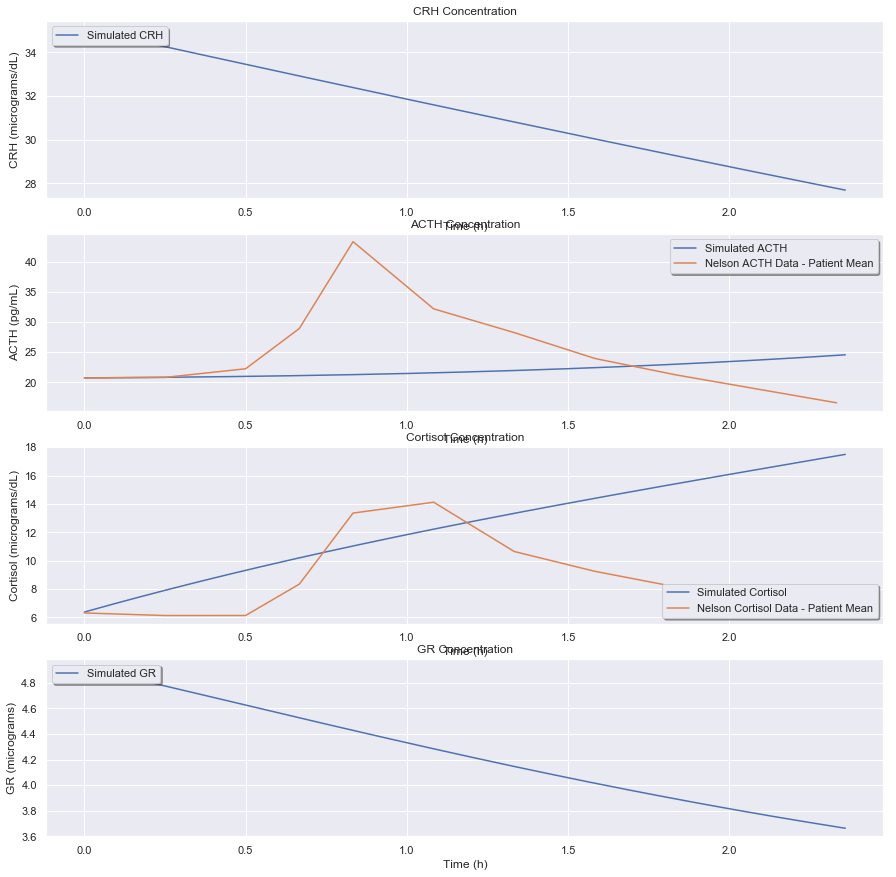

In [207]:
# Run the best parameter set and plot
y0 = [randomParams[int(sortedCostValuesMC[0,0]), 0], nelsonACTH[0,1], nelsonCortisol[0,1], randomParams[int(sortedCostValuesMC[0,0]), 1]]
simData = model(randomParams[int(sortedCostValuesMC[0,0]), 2:], y0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))
ax1.plot(simData[:,0], simData[:,1], label = "Simulated CRH")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "CRH (micrograms/dL)", title = "CRH Concentration")

ax2.plot(simData[:,0], simData[:,2], label = "Simulated ACTH")
ax2.plot(nelsonACTH[:,0], nelsonACTH[:,1], label = "Nelson ACTH Data - Patient Mean")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

ax3.plot(simData[:,0], simData[:,3], label = "Simulated Cortisol")
ax3.plot(nelsonCortisol[:,0], nelsonCortisol[:,1], label = "Nelson Cortisol Data - Patient Mean")
ax3.legend(loc = "lower right", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

ax4.plot(simData[:,0], simData[:,4], label = "Simulated GR")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (h)", ylabel = "GR (micrograms)", title = "GR Concentration")

plt.savefig("sriramModel-nelson-patientMean-IC-opt-MC-covariance_2-normalizedCost.png", dpi = 300)

## Dependencies <a name="dependencies"></a>

In [2]:
%load_ext watermark

In [4]:
%watermark --iversions

numpy     : 1.21.5
matplotlib: 3.0.1
pandas    : 0.23.4
mpld3     : 0.3.1.dev1
scipy     : 1.1.0

